In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
def rgb2gray(rgb, norm=True):
    # Convert RGB to grayscale using the standard formula
    gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])  # RGB to grayscale
    if norm:
        # Normalize the grayscale image to range [-1, 1]
        gray = gray / 128.0 - 1.0
    return gray

# Function to preprocess the state (convert to grayscale, resize to 48x48, and round pixel values)
def preprocess_state(state, size=(96, 96)):
    # Convert the state (RGB) to grayscale (single channel)
    state_gray = rgb2gray(state)
    # state_gray = state

    
    # Resize the grayscale image to 48x48
    state_resized = cv2.resize(state_gray, size, interpolation=cv2.INTER_AREA)
    
    # Round the pixel values to 8 decimal places (this can be considered a form of compression)
    state_resized = np.round(state_resized, 16)
    
    return state_resized

In [ ]:
# Create the CarRacing environment
env = gym.make('CarRacing-v2', domain_randomize = True, render_mode='state_pixels')

# Function to plot the state
def plot_state(state, title="State"):
    plt.imshow(state)
    plt.title(title)
    plt.axis('off')  # Hide axes for clean visualization
    plt.show()

# Run the environment and collect the last 5 states
states = []
for _ in range(5):
    state = env.reset()  # Reset the environment and get the initial state
    done = False
    while not done:
        action = env.action_space.sample()  # Random action (or choose a policy here)
        

        # for i in range(0):
        #     state, reward, done, truncated, info = env.step(action)

        state, reward, done, truncated, info = env.step(action)
        
        # Preprocess the state (round pixel values to 8 decimal places)
        processed_state = preprocess_state(state)
        
        # Store the processed state for later plotting
        states.append(processed_state)
        break  # We only need the first step of each episode for plotting

# Close the environment
env.close()

# Plot the last 5 states
plt.figure(figsize=(15, 15))  # Adjust the figure size
for i, state in enumerate(states):
    # ax = plt.subplot(1, 5, i + 1)
    plot_state(state, title=f"State {i+1}")


In [ ]:
import os
import torch
import gymnasium as gym
import numpy as np
import time
from torch.distributions import Beta
import torch.optim as optim
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import torch.nn as nn

class Net(nn.Module):
    """
    Convolutional Neural Network for PPO
    """

    def __init__(self, img_stack):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v


img_stack=4

transition = np.dtype([('s', np.float64, (img_stack, 96, 96)), 
                       ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (img_stack, 96, 96))])
GAMMA=0.99
EPOCH= 8 # beter than 10
MAX_SIZE = 2000 ## CUDA out of mem for max_size=10000
BATCH=128 
EPS=0.1
LEARNING_RATE = 0.001 # bettr than 0.005 or 0.002 
action_repeat = 10

def rgb2gray(rgb, norm=True):
    # Convert RGB to grayscale using the standard formula
    gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])  # RGB to grayscale
    if norm:
        # Normalize the grayscale image to range [-1, 1]
        gray = gray / 128.0 - 1.0
    return gray
class Agent():
    """ Agent for training """
    
    def __init__(self, device):
        self.training_step = 0
        self.net = Net(img_stack).double().to(device)
        self.buffer = np.empty(MAX_SIZE, dtype=transition)
        self.counter = 0
        self.device = device
        
        self.optimizer = optim.Adam(self.net.parameters(), lr=LEARNING_RATE)  ## lr=1e-3

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(self.device).unsqueeze(0)
        
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp


    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == MAX_SIZE:
            self.counter = 0
            return True
        else:
            return False


agent = Agent('cpu')


class Wrapper:
    """
    Environment wrapper for CarRacing 
    """

    def __init__(self, env, img_stack=4, action_repeat=4):
        self.env = env
        self.img_stack = img_stack
        self.action_repeat = action_repeat
        self.die = False
        self.stack = []
        self.av_r = self.reward_memory()

    def reset(self):
        self.counter = 0
        self.die = False
        img_rgb, _ = self.env.reset()  # Correct unpacking
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * self.img_stack  # Stack the initial frames
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for _ in range(self.action_repeat):  # Loop for action repeats
            action[0] = np.clip(action[0], -1.0, 1.0)  # Steering (-1 to 1)
            action[1] = np.clip(action[1], 0.0, 1.0)   # Gas (0 to 1)
            action[2] = np.clip(action[2], 0.0, 1.0)   # Braking (0 to 1)
            img_rgb, reward, done, truncated, info = self.env.step(action)

            # Apply penalties and rewards
            if self.die:
                reward += 100
            if np.mean(img_rgb[:, :, 1]) > 185.0:  # Green penalty
                reward -= 0.05

            total_reward += reward

            # Calculate rolling average reward to decide on episode termination
            done = True if self.av_r(reward) <= -0.1 else done
            if done or self.die:
                break

        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == self.img_stack

        return np.array(self.stack), total_reward, done, self.die

    @staticmethod
    def reward_memory():
        # Record reward for the last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

    
agent = Agent('cpu')

video_dir = "/Applications/Files/SEM_7/MAJOR/RL/datavideos"  # Path where videos will be saved
os.makedirs(video_dir, exist_ok=True)  # Make sure the directory exists


env = gym.make('CarRacing-v2', verbose=1, render_mode='state_pixels', domain_randomize=True)
# env = gym.wrappers.RecordVideo(env, video_dir, episode_trigger=lambda x: True)  # Record all episodes
env_wrap = Wrapper(env)

# Load Model
def load(agent, directory, filename):
    model_path = os.path.join(directory, filename)
    agent.net.load_state_dict(torch.load(model_path))

# Play Function
from collections import deque

def play(env, agent, n_episodes):
    state = env_wrap.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes + 1):
        state = env_wrap.reset()        
        score = 0
        time_start = time.time()
        
        while True:
            # Select action from the agent
            action, a_logp = agent.select_action(state)
            env.render()

            # Take a step in the wrapped environment
            next_state, reward, done, die = env_wrap.step(
                action * np.array([2.0, 1.0, 1.0]) + np.array([-1.0, 0.0, 0.0])
            )

            state = next_state
            score += reward
            
            if done or die:
                break

        # Record time and performance
        elapsed_time = int(time.time() - time_start)
        scores_deque.append(score)
        scores.append(score)

        print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}, '
              f'\tScore: {score:.2f} \tTime: {elapsed_time // 3600:02}:{elapsed_time % 3600 // 60:02}:{elapsed_time % 60:02}')
    
    return scores


load(agent, '/Applications/Files/SEM_7/MAJOR/RL/model', 'model_weights_800.pth')
play(env, agent, n_episodes=1)

# Close the environment
env.close()


In [ ]:
# import torch
# import numpy as np
# import pygame
# import gymnasium as gym

# def visualize_first_3_feature_maps(agent, env_wrap):
#     """ Visualizes feature maps from the first 3 Conv2D layers in real-time. """
#     model = agent.net
#     model.eval()  # Set model to evaluation mode

#     # Extract only the first 3 Conv layers
#     conv_layers = []
#     count = 0
#     for layer in model.cnn_base.children():
#         if isinstance(layer, torch.nn.Conv2d):
#             conv_layers.append(layer)
#             count += 1
#         if count == 3:  # Stop after 3 layers
#             break

#     pygame.init()
#     TILE_SIZE = 96  # Size of each filter visualization
#     MAX_WIDTH = 800  # Max width of pygame window

#     # Setup Pygame screen for each layer
#     screens = []
#     for layer_index, layer in enumerate(conv_layers):
#         num_filters = layer.weight.shape[0]  # Get number of filters
#         cols = min(num_filters, MAX_WIDTH // TILE_SIZE)  # Arrange filters in grid
#         rows = (num_filters + cols - 1) // cols
#         screen_width, screen_height = cols * TILE_SIZE, rows * TILE_SIZE
#         screen = pygame.display.set_mode((screen_width, screen_height))
#         pygame.display.set_caption(f"Feature Maps - Layer {layer_index + 1}")
#         screens.append(screen)

#     clock = pygame.time.Clock()
    
#     state = env_wrap.reset()
    
#     running = True
#     while running:
#         # Get action and step in environment
#         action, _ = agent.select_action(state)
#         next_state, _, done, die = env_wrap.step(action * np.array([2.0, 1.0, 1.0]) + np.array([-1.0, 0.0, 0.0]))

#         # Convert state to tensor and forward pass through CNN layers
#         state_tensor = torch.from_numpy(state).double().unsqueeze(0).to(agent.device)

#         feature_maps = []
#         x = state_tensor
#         for layer in conv_layers:
#             x = layer(x)  # Forward pass through each layer
#             feature_maps.append(x.squeeze().cpu().detach().numpy())  # Store activations

#         # Render feature maps for each layer
#         for layer_index, fmap in enumerate(feature_maps):
#             num_filters = fmap.shape[0]
#             cols = min(num_filters, MAX_WIDTH // TILE_SIZE)
#             rows = (num_filters + cols - 1) // cols
#             screens[layer_index].fill((0, 0, 0))  # Clear screen

#             for i in range(num_filters):
#                 row, col = divmod(i, cols)
#                 feature_map = fmap[i]

#                 # Normalize feature map to 0-255
#                 feature_map -= feature_map.min()
#                 if feature_map.max() > 0:
#                     feature_map /= feature_map.max()
#                 feature_map *= 255
#                 feature_map = feature_map.astype(np.uint8)

#                 # Convert to RGB format
#                 feature_map = np.stack([feature_map] * 3, axis=-1)
#                 feature_map = np.ascontiguousarray(feature_map)  # Fix memory alignment issues

#                 # Convert to Pygame surface
#                 surf = pygame.surfarray.make_surface(feature_map)
#                 surf = pygame.transform.scale(surf, (TILE_SIZE, TILE_SIZE))
#                 screens[layer_index].blit(surf, (col * TILE_SIZE, row * TILE_SIZE))

#             pygame.display.flip()  # Update display

#         clock.tick(10)  # Slow down rendering for clarity
        
#         # Update state
#         state = next_state

#         # Handle exit
#         for event in pygame.event.get():
#             if event.type == pygame.QUIT:
#                 running = False
#                 break

#         if done or die:
#             break

#     pygame.quit()

# # Run the visualization
# visualize_first_3_feature_maps(agent, env_wrap)
import torch
import numpy as np
import pygame
import gymnasium as gym

def visualize_first_3_feature_maps(agent, env_wrap):
    """ Visualizes feature maps from the first 3 Conv2D layers in real-time. """
    model = agent.net
    model.eval()  # Set model to evaluation mode

    # Extract only the first 3 Conv layers
    conv_layers = []
    count = 0
    for layer in model.cnn_base.children():
        if isinstance(layer, torch.nn.Conv2d):
            conv_layers.append(layer)
            count += 1
        if count == 3:  # Stop after 3 layers
            break

    pygame.init()
    TILE_SIZE = 96  # Size of each filter visualization
    MAX_WIDTH = 800  # Max width of pygame window

    # Setup Pygame screen for each layer
    screens = []
    for layer_index, layer in enumerate(conv_layers):
        num_filters = layer.weight.shape[0]  # Get number of filters
        cols = min(num_filters, MAX_WIDTH // TILE_SIZE)  # Arrange filters in grid
        rows = (num_filters + cols - 1) // cols
        screen_width, screen_height = cols * TILE_SIZE, rows * TILE_SIZE
        screen = pygame.display.set_mode((screen_width, screen_height))
        pygame.display.set_caption(f"Feature Maps - Layer {layer_index + 1}")
        screens.append(screen)

    clock = pygame.time.Clock()
    
    state = env_wrap.reset()
    
    running = True
    while running:
        # Get action and step in environment
        action, _ = agent.select_action(state)
        next_state, _, done, die = env_wrap.step(action * np.array([2.0, 1.0, 1.0]) + np.array([-1.0, 0.0, 0.0]))

        # Convert state to tensor and forward pass through CNN layers
        state_tensor = torch.from_numpy(state).double().unsqueeze(0).to(agent.device)

        feature_maps = []
        x = state_tensor
        for layer in conv_layers:
            x = layer(x)  # Forward pass through each layer
            feature_maps.append(x.squeeze().cpu().detach().numpy())  # Store activations

        # Render feature maps for each layer
        for layer_index, fmap in enumerate(feature_maps):
            num_filters = fmap.shape[0]
            cols = min(num_filters, MAX_WIDTH // TILE_SIZE)
            rows = (num_filters + cols - 1) // cols
            screens[layer_index].fill((0, 0, 0))  # Clear screen

            for i in range(num_filters):
                row, col = divmod(i, cols)
                feature_map = fmap[i]

                # Normalize feature map to 0-255
                feature_map -= feature_map.min()
                if feature_map.max() > 0:
                    feature_map /= feature_map.max()
                feature_map *= 255
                feature_map = feature_map.astype(np.uint8)

                # Convert to RGB format
                feature_map = np.stack([feature_map] * 3, axis=-1)
                feature_map = np.ascontiguousarray(feature_map)  # Fix memory alignment issues

                # Convert to Pygame surface
                surf = pygame.surfarray.make_surface(feature_map)
                surf = pygame.transform.scale(surf, (TILE_SIZE, TILE_SIZE))
                screens[layer_index].blit(surf, (col * TILE_SIZE, row * TILE_SIZE))

            pygame.display.flip()  # Update display

        clock.tick(10)  # Slow down rendering for clarity
        
        # Update state
        state = next_state

        # Handle exit events (event loop)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                break
            elif event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                # Allow user to quit using Escape key
                running = False
                break

        # Check for end of episode
        if done or die:
            running = False
            break
    
    pygame.display.quit()  # Close the display window
    pygame.quit()  # Ensure proper quitting of Pygame
    print("Exited Pygame.")

# Run the visualization
visualize_first_3_feature_maps(agent, env_wrap) 


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def fix_road_color(state):
    """Identifies the road pixels and forces them to be gray, then converts to grayscale."""
    state = np.array(state, dtype=np.uint8)

    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(state, cv2.COLOR_RGB2HSV)

    # Define road color range (tune these values if needed)
    lower_road = np.array([0, 0, 50])   # Dark low-saturation colors
    upper_road = np.array([180, 50, 200])  

    # Create mask for road pixels
    mask = cv2.inRange(hsv, lower_road, upper_road)

    # Apply fixed gray color to detected road regions
    state[mask > 0] = [128, 128, 128]  # Set to gray

    # Convert entire image to grayscale
    gray_state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)

    return gray_state

def plot_all_domains(num_variations=60, cols=6):
    """Plots the first frame of multiple domain-randomized CarRacing-v2 environments in grayscale."""
    rows = (num_variations + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]  # Get first frame
        env.close()

        # Fix the road color and convert to grayscale
        gray_state = fix_road_color(state)

        axes[i].imshow(gray_state, cmap="gray")  # Display in grayscale
        axes[i].axis("off")
        axes[i].set_title(f"Variation {i+1}", fontsize=8)

    for j in range(num_variations, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Run with 36 variations (6x6 grid)
plot_all_domains(num_variations=36, cols=6)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def set_fixed_road_color(state, road_color=(100, 100, 100)):
    """Detects road pixels and sets them to a fixed color."""
    state = np.array(state, dtype=np.uint8)

    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(state, cv2.COLOR_RGB2HSV)

    # Define road color range (tune these values if needed)
    lower_road = np.array([0, 0, 50])   # Dark, low-saturation colors
    upper_road = np.array([180, 50, 200])  

    # Create mask for road pixels
    mask = cv2.inRange(hsv, lower_road, upper_road)

    # Apply fixed road color
    state[mask > 0] = road_color  # Set road to fixed color (dark gray)

    return state

def plot_fixed_road_domains(num_variations=36, cols=6, road_color=(100, 100, 100)):
    """Plots the first frame of multiple domain-randomized CarRacing-v2 environments with a fixed road color."""
    rows = (num_variations + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]  # Get first frame
        env.close()

        # Set fixed road color
        fixed_state = set_fixed_road_color(state, road_color)

        axes[i].imshow(fixed_state)
        axes[i].axis("off")
        axes[i].set_title(f"Variation {i+1}", fontsize=8)

    for j in range(num_variations, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Run with fixed road color (dark gray)
plot_fixed_road_domains(num_variations=100, cols=10, road_color=(100, 100, 100))


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def set_fixed_road_color(state, road_color=(100, 100, 100)):
    """Detects road pixels and sets them to a fixed color."""
    state = np.array(state, dtype=np.uint8)
    hsv = cv2.cvtColor(state, cv2.COLOR_RGB2HSV)

    lower_road = np.array([0, 0, 50])
    upper_road = np.array([180, 50, 200])
    mask = cv2.inRange(hsv, lower_road, upper_road)

    state[mask > 0] = road_color
    return state

def apply_filters(image):
    """Apply edge detection and contour filters."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # 1. Sobel Edge Detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    sobel_combined = np.uint8(np.clip(sobel_combined, 0, 255))

    # 2. Canny Edge Detection
    canny = cv2.Canny(gray, 100, 200)

    # 3. Contours
    contours, _ = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(image)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

    return sobel_combined, canny, contour_img

def plot_filtered_road_domains(num_variations=10, cols=10, road_color=(100, 100, 100)):
    rows = num_variations
    fig, axes = plt.subplots(rows, 4, figsize=(16, 2 * rows))  # 4 columns: Original, Sobel, Canny, Contours

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        
        # Take 10 random steps to advance the environment
        for _ in range(10):
            random_action = env.action_space.sample()
            state, _, done, _, _ = env.step(random_action)
            if done:
                break
        env.close()

        fixed_state = set_fixed_road_color(state, road_color)
        sobel, canny, contour = apply_filters(fixed_state)

        axes[i][0].imshow(fixed_state)
        axes[i][0].set_title(f"Orig #{i+1}")
        axes[i][1].imshow(sobel, cmap='gray')
        axes[i][1].set_title("Sobel")
        axes[i][2].imshow(canny, cmap='gray')
        axes[i][2].set_title("Canny")
        axes[i][3].imshow(contour)
        axes[i][3].set_title("Contours")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run the filtered visualization
plot_filtered_road_domains(num_variations=20, cols=10, road_color=(100, 100, 100))


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def set_fixed_road_color(state, road_color=(100, 100, 100)):
    # """Smart road color fixer: avoids similar-looking grass and patterned textures."""
    # state = np.array(state, dtype=np.uint8)
    # hsv = cv2.cvtColor(state, cv2.COLOR_RGB2HSV)

    # # Basic HSV mask (adjusted)
    # lower_road = np.array([0, 0, 40])     # broader low-saturation range
    # upper_road = np.array([180, 50, 220]) 

    # color_mask = cv2.inRange(hsv, lower_road, upper_road)

    # # Remove small noisy textures using morphological opening
    # kernel = np.ones((5, 5), np.uint8)
    # clean_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, kernel)

    # # Optional: keep only bottom half of image where road usually is
    # h, w = clean_mask.shape
    # position_mask = np.zeros_like(clean_mask)
    # position_mask[h//2:, :] = 255
    # final_mask = cv2.bitwise_and(clean_mask, position_mask)

    # # Apply fixed color to road
    # state[final_mask > 0] = road_color

    return state


def apply_filters(image):
    """Apply multiple edge detection filters."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # 1. Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.uint8(np.clip(cv2.magnitude(sobelx, sobely), 0, 255))

    # 2. Scharr
    scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    scharr = np.uint8(np.clip(cv2.magnitude(scharrx, scharry), 0, 255))

    # 3. Canny
    canny = cv2.Canny(gray, 100, 200)

    # 4. Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = np.uint8(np.clip(np.absolute(laplacian), 0, 255))

    return sobel, scharr, canny, laplacian

def plot_edge_comparisons(num_variations=10, road_color=(100, 100, 100)):
    fig, axes = plt.subplots(num_variations, 5, figsize=(18, 2 * num_variations))
    titles = ["Original", "Sobel", "Scharr", "Canny", "Laplacian"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        # Take 10 random steps
        for _ in range(20):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        fixed_state = set_fixed_road_color(state, road_color)
        sobel, scharr, canny, laplacian = apply_filters(fixed_state)

        # Plot all results
        images = [fixed_state, sobel, scharr, canny, laplacian]
        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visual comparison
plot_edge_comparisons(num_variations=20, road_color=(100, 100, 100))



In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def set_fixed_road_color(state, road_color=(100, 100, 100)):
    # """Smart road color fixer: avoids similar-looking grass and patterned textures."""
    # state = np.array(state, dtype=np.uint8)
    # hsv = cv2.cvtColor(state, cv2.COLOR_RGB2HSV)

    # lower_road = np.array([0, 0, 40])
    # upper_road = np.array([180, 50, 220])
    # color_mask = cv2.inRange(hsv, lower_road, upper_road)

    # kernel = np.ones((5, 5), np.uint8)
    # clean_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, kernel)

    # h, w = clean_mask.shape
    # position_mask = np.zeros_like(clean_mask)
    # position_mask[h//2:, :] = 255
    # final_mask = cv2.bitwise_and(clean_mask, position_mask)

    # state[final_mask > 0] = road_color
    return state

def combine_edge_filters(gray):
    # # === Scharr ===
    # scharrx = cv2.Scharr(image, cv2.CV_64F, 1, 0)
    # scharry = cv2.Scharr(image, cv2.CV_64F, 0, 1)
    # scharr = cv2.magnitude(scharrx, scharry)

    # # === Sobel ===
    # sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    # sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    # sobel = cv2.magnitude(sobelx, sobely)

    # # === Fusion (No normalize) ===
    # # Try exact sobel only
    # fused = cv2.magnitude(sobel,sobel)

    # # Normalize final output to uint8
    # fused_uint8 = cv2.normalize(fused, None, 0, 255, cv2.NORM_MINMAX)
    # fused_uint8 = fused_uint8.astype(np.uint8)

    # return fused_uint8

    # === 1. Sobel ===
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)

    # Normalize Sobel to 0–255 for display and contour detection
    sobel_uint8 = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # === 2. Contour Detection ===
    # Threshold to get binary image
    _, binary = cv2.threshold(sobel_uint8, 50, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # === 3. Draw contours on top of Sobel ===
    sobel_contour = cv2.cvtColor(sobel_uint8, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(sobel_contour, contours, -1, (0, 255, 0), 1)  # green lines

    return sobel_contour




def apply_filters(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply individual filters
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.uint8(np.clip(cv2.magnitude(sobelx, sobely), 0, 255))

    scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    scharr = np.uint8(np.clip(cv2.magnitude(scharrx, scharry), 0, 255))

    canny = cv2.Canny(gray, 100, 200)

    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = np.uint8(np.clip(np.absolute(laplacian), 0, 255))

    fused = combine_edge_filters(gray)

    return sobel, scharr, canny, laplacian, fused

def plot_edge_comparisons(num_variations=10, road_color=(100, 100, 100)):
    fig, axes = plt.subplots(num_variations, 6, figsize=(20, 2.2 * num_variations))
    titles = ["Original", "Sobel", "Scharr", "Canny", "Laplacian", "Fused"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(10):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        fixed_state = set_fixed_road_color(state, road_color)
        sobel, scharr, canny, laplacian, fused = apply_filters(fixed_state)

        images = [fixed_state, sobel, scharr, canny, laplacian, fused]
        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the comparison with fused edge enhancement
plot_edge_comparisons(num_variations=20, road_color=(100, 100, 100))


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def set_fixed_road_color(state, road_color=(100, 100, 100)):
    """Mockup for setting road color. You can define this as per your needs."""
    return state

def combine_sobel_and_scharr(gray):
    # === Sobel ===
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)

    # === Scharr ===
    scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    scharr = cv2.magnitude(scharrx, scharry)

    # Normalize to 0-255 for contour detection
    sobel_uint8 = np.uint8(cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX))
    scharr_uint8 = np.uint8(cv2.normalize(scharr, None, 0, 255, cv2.NORM_MINMAX))

    return sobel_uint8, scharr_uint8

def apply_contours(base_image):
    # Threshold to get binary image
    _, binary = cv2.threshold(base_image, 50, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on top of base image
    contour_image = cv2.cvtColor(base_image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1)  # green contours

    return contour_image

def apply_filters(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Get Sobel and Scharr edges
    sobel, scharr = combine_sobel_and_scharr(gray)

    # Apply contour detection
    sobel_contour = apply_contours(sobel)
    scharr_contour = apply_contours(scharr)

    # Apply Canny on Sobel and Scharr
    canny_sobel = cv2.Canny(sobel, 100, 200)
    canny_scharr = cv2.Canny(scharr, 100, 200)

    # Possible combinations
    results = {
        "original": image,
        "sobel_only": sobel,
        "scharr_only": scharr,
        "sobel_with_contours": sobel_contour,
        "scharr_with_contours": scharr_contour,
        "canny_on_sobel": canny_sobel,
        "canny_on_scharr": canny_scharr
    }

    return results

def plot_edge_combinations(num_variations=10, road_color=(100, 100, 100)):
    fig, axes = plt.subplots(num_variations, 7, figsize=(24, 2.4 * num_variations))
    titles = ["Original", "Sobel", "Scharr", "Sobel + Contours", "Scharr + Contours", "Canny on Sobel", "Canny on Scharr"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(10):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        fixed_state = set_fixed_road_color(state, road_color)
        filters = apply_filters(fixed_state)

        # Show the results
        images = [
            filters["original"],
            filters["sobel_only"],
            filters["scharr_only"],
            filters["sobel_with_contours"],
            filters["scharr_with_contours"],
            filters["canny_on_sobel"],
            filters["canny_on_scharr"]
        ]
        
        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the comparison with fused edge enhancement
plot_edge_combinations(num_variations=10, road_color=(100, 100, 100))


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def adjust_saturation(image, factor=1.5):
    """Increase saturation by a factor."""
    # Convert image to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Increase the saturation channel by the given factor
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    
    # Convert back to RGB
    saturated_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return saturated_image

def adjust_brightness(image, factor=1.5):
    """Increase brightness (exposure) of the image."""
    # Convert the image to float to prevent clipping during calculations
    image_float = np.float32(image)
    
    # Increase the exposure (brightness) by multiplying by the factor
    brightened_image = np.clip(image_float * factor, 0, 255)
    
    # Convert back to uint8
    brightened_image = np.uint8(brightened_image)
    return brightened_image

def set_fixed_road_color(state, road_color=(100, 100, 100)):
    """Mockup for setting road color."""
    return state

def plot_brightness_saturation_combos(num_variations=5):
    fig, axes = plt.subplots(num_variations, 4, figsize=(16, 2.2 * num_variations))
    titles = ["Original", "Increased Brightness", "Increased Saturation", "Brightness + Saturation"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(10):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        # Apply saturation and exposure adjustments
        brightened_state = adjust_brightness(state, factor=2)  # Adjust brightness
        saturated_state = adjust_saturation(state, factor=0.5)  # Adjust saturation
        combined_state = adjust_saturation(brightened_state, factor=1.4)  # Apply both

        # Create a list of the images to plot
        images = [
            state,              # Original
            brightened_state,   # Increased Brightness
            saturated_state,    # Increased Saturation
            combined_state      # Both Brightness + Saturation
        ]
        
        # Plot the images
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the brightness and saturation comparison
plot_brightness_saturation_combos(num_variations=20)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def set_fixed_road_color(state, road_color=(100, 100, 100)):
    """Mockup for setting road color."""
    return state

def adjust_brightness(image, factor=1.5):
    """Increase brightness (exposure) of the image."""
    image_float = np.float32(image)
    brightened_image = np.clip(image_float * factor, 0, 255)
    brightened_image = np.uint8(brightened_image)
    return brightened_image

def adjust_saturation(image, factor=1.5):
    """Adjust the saturation of the image."""
    # Convert the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Adjust the saturation channel
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * factor, 0, 255)
    
    # Convert back to RGB
    saturated_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return saturated_image

def apply_sobel(image):
    """Apply Sobel edge detection to the image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    scharr = np.uint8(np.clip(cv2.magnitude(scharrx, scharry), 0, 255))
    
    return scharr

def plot_sobel_with_adjustments(num_variations=10, road_color=(100, 100, 100)):
    fig, axes = plt.subplots(num_variations, 4, figsize=(16, 2.4 * num_variations))
    titles = ["Original", "Brightness Adjusted", "Saturation Adjusted", "Sobel + Adjustments"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(10):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        # Set fixed road color
        fixed_state = set_fixed_road_color(state, road_color)

        # Apply brightness and saturation adjustments
        brightened_state = adjust_brightness(fixed_state, factor=2.5)  # Adjust brightness
        saturated_state = adjust_saturation(fixed_state, factor=2.5)  # Adjust saturation
        combined_state = adjust_saturation(brightened_state, factor=1.4)  # Apply both

        # Apply Sobel to the adjusted images
        sobel_bright = apply_sobel(brightened_state)
        sobel_satur = apply_sobel(saturated_state)
        sobel_combined = apply_sobel(saturated_state)

        # Show the results
        images = [
            fixed_state,  # Original
            brightened_state,  # Brightness Adjusted
            saturated_state,  # Saturation Adjusted
            sobel_combined  # Sobel after both adjustments
        ]

        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the comparison with Sobel applied after adjustments
plot_sobel_with_adjustments(num_variations=20, road_color=(100, 100, 100))


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def adjust_brightness(image, factor=1.5):
    """Increase brightness (exposure) of the image."""
    image_float = np.float32(image)
    brightened_image = np.clip(image_float * factor, 0, 255)
    return np.uint8(brightened_image)

def adjust_saturation(image, factor=1.5):
    """Adjust the saturation of the image."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def apply_scharr(image):
    """Apply Scharr edge detection to the image (more accurate Sobel)."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    scharr = cv2.magnitude(scharrx, scharry)
    return np.uint8(np.clip(scharr, 0, 255))

def apply_laplacian(image):
    """Apply Laplacian edge detection to the image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    # Take absolute and convert to 8-bit for display
    laplacian = np.uint8(np.clip(np.absolute(laplacian), 0, 255))
    return laplacian


def plot_pipeline(num_variations=10):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.5 * num_variations))
    titles = ["Original", "Brightness Adjusted", "Brightness + Saturation", "Scharr Edges"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(10):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        # Step 1: Brightness
        brightened = adjust_brightness(state, factor=2.0)

        # Step 2: Saturation (on brightened)
        adjusted = adjust_saturation(brightened, factor=0.091)

        # Step 3: Scharr edge detection
        edges = apply_scharr(adjusted)
        # edges = apply_laplacian(adjusted)

        brightened = adjust_brightness(edges, factor=2)


        # Show results
        images = [state, brightened, adjusted, edges]

        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=11)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visual pipeline
plot_pipeline(num_variations=50)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def adjust_brightness(image, factor=1.5):
    """Increase brightness (exposure) of the image."""
    image_float = np.float32(image)
    brightened_image = np.clip(image_float * factor, 0, 255)
    return np.uint8(brightened_image)

def adjust_saturation(image, factor=1.5):
    """Adjust the saturation of the image."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def apply_scharr(image):
    """Apply Scharr edge detection to the image (more accurate Sobel)."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    scharr = cv2.magnitude(scharrx, scharry)
    return np.uint8(np.clip(scharr, 0, 255))

def apply_canny(image, threshold1=50, threshold2=150):
    """Apply Canny edge detection to the image."""
    # Assume image is already grayscale (like output from Scharr)
    return cv2.Canny(image, threshold1, threshold2)


def apply_laplacian(image):
    """Apply Laplacian edge detection to the image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return np.uint8(np.clip(np.absolute(laplacian), 0, 255))

def apply_average_blur(image, ksize=5):
    """Apply averaging filter (box blur) to the image."""
    return cv2.blur(image, (ksize, ksize))

def plot_pipeline(num_variations=10):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.5 * num_variations))
    titles = ["Original", "Blurred + Brightness", "Brightness + Saturation", "Scharr Edges"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        # Step 1: Blur the original frame
        blurred = apply_average_blur(state, ksize=5)
        blurred = apply_average_blur(blurred, ksize=3)


        # Step 2: Brightness on blurred image
        brightened = adjust_brightness(blurred, factor=2.0)
        
        # brightened = apply_average_blur(brightened, ksize=2)


        # Step 3: Saturation (on brightened)
        adjusted = adjust_saturation(brightened, factor=1.5)

        # Step 4: Edge detection (Scharr)
        edges_1 = apply_scharr(adjusted)

        # # Optional: Boost brightness of edge map for visibility
        edges = adjust_brightness(edges_1, factor=1)


        # Show results
        images = [state, brightened, edges_1, edges]

        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=11)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visual pipeline
plot_pipeline(num_variations=20)


# Best Till Now


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def adjust_brightness(image, factor=1.5):
    """Increase brightness (exposure) of the image."""
    image_float = np.float32(image)
    brightened_image = np.clip(image_float * factor, 0, 255)
    return np.uint8(brightened_image)

def adjust_saturation(image, factor=1.5):
    """Adjust the saturation of the image."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def apply_average_blur(image, ksize=5):
    """Apply averaging filter (box blur) to the image."""
    return cv2.blur(image, (ksize, ksize))

def apply_canny(image, threshold1=50, threshold2=150):
    """Apply Canny edge detection to the image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1, threshold2)
    return edges

def plot_pipeline(num_variations=10):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.5 * num_variations))
    titles = ["Original", "Brightness Adjusted", "Saturation Adjusted", "Canny Edges"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        # Step 1: Apply brightness first
        brightened = adjust_brightness(state, factor=3)

        # Step 2: Apply blur filter on the brightened image
        blurred = apply_average_blur(brightened, ksize=3)
        blurred = apply_average_blur(blurred, ksize=5)

        # Step 3: Adjust saturation (on blurred image)
        adjusted = adjust_saturation(blurred, factor=1.5)

        # Step 4: Apply Canny edge detection
        edges_1 = apply_canny(adjusted, threshold1=20, threshold2=50)

        # Show results
        images = [state, brightened, adjusted, edges_1]

        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=11)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visual pipeline
plot_pipeline(num_variations=20)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def adjust_brightness(image, factor=1.2):
    """Increase brightness (exposure) of the image moderately."""
    image_float = np.float32(image)
    brightened_image = np.clip(image_float * factor, 0, 255)
    return np.uint8(brightened_image)

def apply_average_blur(image, ksize=5):
    """Apply averaging filter (box blur) to the image."""
    return cv2.blur(image, (ksize, ksize))

def apply_canny(image, threshold1=50, threshold2=150):
    """Apply Canny edge detection to the image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1, threshold2)
    return edges

def apply_morphological_operations(edges, kernel_size=(5, 5)):
    """Apply dilation and erosion to clean up edges."""
    kernel = np.ones(kernel_size, np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    return eroded

def convert_to_hsv_and_enhance(image, saturation_factor=1.2, value_factor=1.2):
    """Convert to HSV and enhance the saturation and brightness."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)  # Saturation
    hsv_image[..., 2] = np.clip(hsv_image[..., 2] * value_factor, 0, 255)  # Value (brightness)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def fill_edges(edges):
    """Fill the edges to isolate the track (white) and background (black)."""
    filled = np.zeros_like(edges)
    filled[edges == 255] = 255
    return filled

def plot_pipeline(num_variations=10):
    fig, axes = plt.subplots(num_variations, 5, figsize=(18, 2.5 * num_variations))
    titles = ["Original", "Brightness Adjusted", "Blurred Image", "Edges", "Filled Edges"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        # Step 1: Apply brightness moderately
        brightened = adjust_brightness(state, factor=2.0)  # Moderate brightness adjustment

        # Step 2: Apply blur filter on the brightened image
        blurred = apply_average_blur(brightened, ksize=3)
        blurred = apply_average_blur(blurred, ksize=5)

        # Step 3: Enhance the image in HSV color space (for better color separation)
        enhanced = convert_to_hsv_and_enhance(blurred, saturation_factor=1.1, value_factor=1.1)

        # Step 4: Apply Canny edge detection
        # edges = apply_canny(enhanced, threshold1=20, threshold2=70)
        edges = apply_scharr(enhanced)

        # Step 5: Apply morphological operations to clean up edges
        cleaned_edges = apply_morphological_operations(edges)

        # Step 6: Fill the edges to isolate the track
        filled_edges = fill_edges(cleaned_edges)

        # Show results
        images = [state, brightened, blurred, edges, filled_edges]

        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=11)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visual pipeline
plot_pipeline(num_variations=20)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def adjust_brightness(image, factor=1.2):
    """Increase brightness (exposure) of the image moderately."""
    image_float = np.float32(image)
    brightened_image = np.clip(image_float * factor, 0, 255)
    return np.uint8(brightened_image)

def apply_average_blur(image, ksize=5):
    """Apply averaging filter (box blur) to the image."""
    return cv2.blur(image, (ksize, ksize))

def apply_canny(image, threshold1=50, threshold2=150):
    """Apply Canny edge detection to the image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1, threshold2)
    return edges

def apply_morphological_operations(edges, kernel_size=(5, 5)):
    """Apply dilation and erosion to clean up edges."""
    kernel = np.ones(kernel_size, np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    return eroded

def convert_to_hsv_and_enhance(image, saturation_factor=1.2, value_factor=1.2):
    """Convert to HSV and enhance the saturation and brightness."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)  # Saturation
    hsv_image[..., 2] = np.clip(hsv_image[..., 2] * value_factor, 0, 255)  # Value (brightness)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def find_and_fill_contours(edges):
    """Find contours in the edge-detected image and fill the largest ones (track)."""
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty black mask to fill the contours
    filled_image = np.zeros_like(edges)

    # Filter and fill the contours (you can adjust the contour area based on track size)
    for contour in contours:
        # Use contour area to filter out small contours
        if cv2.contourArea(contour) > 500:  # Adjust the threshold value as needed
            cv2.drawContours(filled_image, [contour], -1, 255, thickness=cv2.FILLED)

    return filled_image

def plot_pipeline(num_variations=10):
    fig, axes = plt.subplots(num_variations, 5, figsize=(18, 2.5 * num_variations))
    titles = ["Original", "Brightness Adjusted", "Blurred Image", "Edges", "Contours Filled"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break

        env.close()

        # Step 1: Apply brightness moderately
        brightened = adjust_brightness(state, factor=1.2)  # Moderate brightness adjustment

        # Step 2: Apply blur filter on the brightened image
        blurred = apply_average_blur(brightened, ksize=3)
        blurred = apply_average_blur(blurred, ksize=5)

        # Step 3: Enhance the image in HSV color space (for better color separation)
        enhanced = convert_to_hsv_and_enhance(blurred, saturation_factor=1.3, value_factor=1.5)

        # Step 4: Apply Canny edge detection
        edges = apply_canny(enhanced, threshold1=50, threshold2=50)

        # Step 5: Apply morphological operations to clean up edges
        cleaned_edges = apply_morphological_operations(edges)

        # Step 6: Find and fill contours to isolate the track
        filled_contours = find_and_fill_contours(cleaned_edges)

        # Show results
        images = [state, brightened, blurred, edges, filled_contours]

        for j, img in enumerate(images):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=11)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visual pipeline
plot_pipeline(num_variations=10)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def extract_center_color(image, region_size=5):
    """Get the average color of a small center region."""
    h, w, _ = image.shape
    cx, cy = w // 2, h // 2
    region = image[cy - region_size//2 : cy + region_size//2,
                   cx - region_size//2 : cx + region_size//2]
    avg_color = np.mean(region, axis=(0, 1))  # RGB
    return avg_color

def extract_track_by_center_color(image, tolerance=30, region_size=5):
    """Create a mask where colors close to the center color are white, rest black."""
    center_color = extract_center_color(image, region_size)

    diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
    diff_sum = np.sum(diff, axis=2)

    # Binary mask: similar to center color → white
    mask = np.uint8(diff_sum < tolerance) * 255

    # Morph cleanup
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask

def plot_pipeline(num_variations=10):
    fig, axes = plt.subplots(num_variations, 3, figsize=(14, 2.8 * num_variations))
    titles = ["Original", "Track Mask (Raw)", "Track Mask (Cleaned)"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # Get raw mask
        center_color = extract_center_color(state, region_size=5)
        diff = np.abs(state.astype(np.int16) - center_color.astype(np.int16))
        diff_sum = np.sum(diff, axis=2)
        raw_mask = np.uint8(diff_sum < 30) * 255  # raw, before morph ops

        # Cleaned mask
        cleaned_mask = extract_track_by_center_color(state, tolerance=30, region_size=5)

        # Show results
        images = [state, raw_mask, cleaned_mask]
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the pipeline
plot_pipeline(num_variations=100)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def adjust_saturation(image, factor=3.5):
    """Increase saturation of the image in HSV space."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_GRAY2RGB)

def extract_center_color(image, region_size=7):
    """Get the average color of a small center region."""
    h, w, _ = image.shape
    cx, cy = w // 2, h // 2
    region = image[cy - region_size//2 : cy + region_size//2,
                   cx - region_size//2 : cx + region_size//2]
    avg_color = np.mean(region, axis=(0, 1))  # RGB
    return avg_color

def extract_track_by_center_color_lab(image, tolerance=20, region_size=7):
    """Use LAB color distance from center region to extract track mask."""
    lab_img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    center_rgb = extract_center_color(image, region_size)
    center_rgb = np.uint8([[center_rgb]])
    center_lab = cv2.cvtColor(center_rgb, cv2.COLOR_RGB2LAB)[0][0]

    diff = lab_img.astype(np.int16) - center_lab.astype(np.int16)
    dist = np.sqrt(np.sum(diff ** 2, axis=2))

    raw_mask = np.uint8(dist < tolerance) * 255

    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

    return raw_mask, cleaned

def keep_largest_contour(mask):
    """Optional: Keep only the largest contour (likely the track)."""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest = np.zeros_like(mask)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(largest, [largest_contour], -1, 255, thickness=cv2.FILLED)
    return largest

def plot_pipeline(num_variations=10, saturation_boost=1.7, lab_tolerance=10):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.8 * num_variations))
    titles = ["Original", "Saturation Boosted", "Track Mask (Cleaned)", "Largest Contour Only"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]

        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # Step 1: Boost saturation to enhance color contrast
        saturated = adjust_saturation(state, factor=saturation_boost)

        # Step 2: Extract track based on LAB color distance
        _, cleaned_mask = extract_track_by_center_color_lab(saturated, tolerance=lab_tolerance, region_size=3)


        # Show results
        images = [state, saturated, cleaned_mask, cleaned_mask]
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the pipeline
plot_pipeline(num_variations=200)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Step 1: Blur the original frame
def apply_average_blur(image, ksize=5):
    return cv2.blur(image, (ksize, ksize))

# Step 2: Brightness adjustment
def adjust_brightness(image, factor=2.0):
    image_float = np.float32(image)
    brightened = np.clip(image_float * factor, 0, 255)
    return np.uint8(brightened)

# Step 3: Saturation adjustment in HSV space
def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# Step 4: Extract center color (Average color of the center region)
def extract_center_color(image, region_size=7):
    h, w, _ = image.shape
    cx, cy = w // 2, h // 2
    region = image[cy - region_size//2 : cy + region_size//2,
                   cx - region_size//2 : cx + region_size//2]
    avg_color = np.mean(region, axis=(0, 1))  # RGB
    return avg_color

# Step 5: Track extraction based on LAB distance
def extract_track_by_center_color_lab(image, tolerance=20, region_size=7):
    lab_img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    center_rgb = extract_center_color(image, region_size)
    center_rgb = np.uint8([[center_rgb]])
    center_lab = cv2.cvtColor(center_rgb, cv2.COLOR_RGB2LAB)[0][0]

    diff = lab_img.astype(np.float32) - center_lab.astype(np.float32)
    dist = np.sqrt(np.sum(diff ** 2, axis=2))

    raw_mask = np.uint8(dist < tolerance) * 255

    # Morphological cleanup
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

    return raw_mask, cleaned

# Step 6: Optional function to keep the largest contour (likely the track)
def keep_largest_contour(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest = np.zeros_like(mask)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(largest, [largest_contour], -1, 255, thickness=cv2.FILLED)
    return largest

def plot_pipeline(num_variations=10):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.8 * num_variations))
    titles = ["Original", "Blurred & Brightened", "Saturation Adjusted", "Track Mask (Cleaned)"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()


        # Step 2: Apply brightness adjustment
        brightened = adjust_brightness(state, factor=1.5)

        # Step 3: Apply saturation adjustment on the brightened image
        adjusted = adjust_saturation(brightened, factor=2.1)

        # Step 4: Use the LAB method for track extraction
        _, cleaned_mask = extract_track_by_center_color_lab(adjusted, tolerance=10, region_size=3)

        # Step 5: Optionally keep only the largest contour (track)

        # Show the results
        images = [state, brightened, adjusted, cleaned_mask]
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the pipeline with a few variations
plot_pipeline(num_variations=100)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def apply_average_blur(image, ksize=3):
    return cv2.blur(image, (ksize, ksize))

def adjust_brightness(image, factor=1.5):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_center_color(image, region_size=7):
    h, w, _ = image.shape
    cx, cy = w // 2, h // 2
    region = image[cy - region_size//2 : cy + region_size//2,
                   cx - region_size//2 : cx + region_size//2]
    avg_color = np.mean(region, axis=(0, 1))
    return avg_color

def extract_track_by_center_color_rgb(image, tolerance=25, region_size=7):
    center_color = extract_center_color(image, region_size)
    diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
    diff_sum = np.sum(diff, axis=2)
    mask = np.uint8(diff_sum < tolerance) * 255

    # Morph cleanup
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask, cleaned

def plot_pipeline(num_variations=10, rgb_tolerance=25):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.8 * num_variations))
    titles = ["Original", "Preprocessed", "Track Mask (Raw)", "Track Mask (Cleaned)"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Preprocessing Pipeline ===
        blurred = apply_average_blur(state, ksize=3)
        brightened = adjust_brightness(blurred, factor=0.9)
        saturated = adjust_saturation(brightened, factor=1.5)

        # === Color similarity in RGB ===
        raw_mask, cleaned_mask = extract_track_by_center_color_rgb(saturated, tolerance=rgb_tolerance, region_size=5)

        # === Visualization ===
        images = [state, saturated, raw_mask, cleaned_mask]
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the pipeline
plot_pipeline(num_variations=200, rgb_tolerance=20)

#1 BEST 


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def apply_average_blur(image, ksize=3):
    return cv2.blur(image, (ksize, ksize))

def adjust_brightness(image, factor=1.5):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extra_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_center_color_gray(image, region_size=7):
    h, w = image.shape
    cx, cy = w // 2, h // 2
    region = image[cy - region_size//2 : cy + region_size//2,
                   cx - region_size//2 : cx + region_size//2]
    avg_color = np.mean(region)
    return avg_color

def extract_track_by_center_color_gray(image, tolerance=15, region_size=5):
    center_color = extract_center_color_gray(image, region_size)
    diff = np.abs(image.astype(np.int16) - int(center_color))
    mask = np.uint8(diff < tolerance) * 255

    # Morph cleanup
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask, cleaned

def plot_pipeline(num_variations=10, gray_tolerance=15):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.8 * num_variations))
    titles = ["Original", "Grayscale", "Track Mask (Raw)", "Track Mask (Cleaned)"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(17):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Preprocessing ===
        blurred = apply_average_blur(state, ksize=3)
        blurred = apply_average_blur(state, ksize=3)

        brightened = adjust_brightness(blurred, factor=0.9)
        saturated = adjust_saturation(brightened, factor=1.5)

        # === Convert to Grayscale ===
        gray = cv2.cvtColor(saturated, cv2.COLOR_RGB2GRAY)
        gray = extra_saturation(gray, factor=1.5)


        # === Track Extraction ===
        raw_mask, cleaned_mask = extract_track_by_center_color_gray(gray, tolerance=gray_tolerance, region_size=5)

        # === Visualization ===
        images = [state, gray, raw_mask, cleaned_mask]
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run it!
plot_pipeline(num_variations=200, gray_tolerance=5)


In [ ]:
# TESTING FINAL

import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def apply_average_blur(image, ksize=3):
    return cv2.blur(image, (ksize, ksize))

def adjust_brightness(image, factor=1.5):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_center_color(image, region_size=7):
    h, w, _ = image.shape
    cx, cy = w // 2, h // 2
    region = image[cy - region_size//2 : cy + region_size//2,
                   cx - region_size//2 : cx + region_size//2]
    avg_color = np.mean(region, axis=(0, 1))
    return avg_color

def extract_track_by_center_color_rgb(image, tolerance=25, region_size=7):
    center_color = extract_center_color(image, region_size)
    diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
    diff_sum = np.sum(diff, axis=2)
    mask = np.uint8(diff_sum < tolerance) * 255

    # Morph cleanup
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask, cleaned

def plot_pipeline(num_variations=10, rgb_tolerance=25):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.8 * num_variations))
    titles = ["Original", "Preprocessed", "Track Mask (Raw)", "Track Mask (Cleaned)"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Preprocessing Pipeline ===
        blurred = apply_average_blur(state, ksize=3)
        blurred = apply_average_blur(state, ksize=3)
        brightened = adjust_brightness(blurred, factor=0.9)
        saturated = adjust_saturation(brightened, factor=1.5)

        # === Color similarity in RGB ===
        raw_mask, cleaned_mask = extract_track_by_center_color_rgb(saturated, tolerance=rgb_tolerance, region_size=7)

        # === Visualization ===
        images = [state, saturated, raw_mask, cleaned_mask]
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the pipeline
plot_pipeline(num_variations=10, rgb_tolerance=20)

#2 BEST 


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def apply_average_blur(image, ksize=3):
    return cv2.blur(image, (ksize, ksize))

def adjust_brightness(image, factor=1.5):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_center_color(image, region_size=7):
    h, w, _ = image.shape
    cx, cy = w // 2, h // 2
    region = image[cy - region_size//2 : cy + region_size//2,
                   cx - region_size//2 : cx + region_size//2]
    avg_color = np.mean(region, axis=(0, 1))
    return avg_color

def extract_track_by_center_color_rgb(image, tolerance=25, region_size=7):
    center_color = extract_center_color(image, region_size)
    diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
    diff_sum = np.sum(diff, axis=2)
    mask = np.uint8(diff_sum < tolerance) * 255

    # Morph cleanup
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask, cleaned

def draw_center_square(image, region_size=7, color=(255, 0, 0)):
    """Draw a square on the image at the center used for color sampling."""
    cx, cy = image.shape[1] // 2, image.shape[0] // 2
    x1, y1 = cx - region_size // 2, cy - region_size // 2
    x2, y2 = cx + region_size // 2, cy + region_size // 2
    return cv2.rectangle(image.copy(), (x1, y1), (x2, y2), color, thickness=1)

def plot_pipeline(num_variations=10, rgb_tolerance=25):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.8 * num_variations))
    titles = ["Original", "Preprocessed + Center", "Track Mask (Raw)", "Track Mask (Cleaned)"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(25):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Preprocessing Pipeline ===
        blurred = apply_average_blur(state, ksize=3)
        # blurred = apply_average_blur(blurred, ksize=2)
        blurred = apply_average_blur(blurred, ksize=2)

        brightened = adjust_brightness(blurred, factor=1.5)
        saturated = adjust_saturation(brightened, factor=1.5)

        # Draw square on preprocessed
        preprocessed_with_square = draw_center_square(saturated, region_size=5)

        # === Color similarity in RGB ===
        raw_mask, cleaned_mask = extract_track_by_center_color_rgb(saturated, tolerance=rgb_tolerance, region_size=5)

        # === Visualization ===
        images = [state, preprocessed_with_square, raw_mask, cleaned_mask]
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the pipeline
plot_pipeline(num_variations=10, rgb_tolerance=20)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

def apply_gaussian_blur(image, ksize=3):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def adjust_brightness(image, factor=1.5):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_multi_center_color(image, region_size=7, offset_y=10):
    h, w, _ = image.shape
    cx = w // 2
    cy = h // 2

    offsets = [-offset_y, 0, offset_y]
    colors = []
    boxes = []

    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = image[y1:y2, x1:x2]
        colors.append(np.mean(region, axis=(0, 1)))
        boxes.append(((x1, y1), (x2, y2)))

    avg_color = np.mean(colors, axis=0)
    return avg_color, boxes

def extract_track_by_center_color_rgb(image, tolerance=25, region_size=7):
    center_color, _ = extract_multi_center_color(image, region_size)
    diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
    diff_sum = np.sum(diff, axis=2)
    mask = np.uint8(diff_sum < tolerance) * 255

    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask, cleaned

def plot_pipeline(num_variations=10, rgb_tolerance=20):
    fig, axes = plt.subplots(num_variations, 4, figsize=(18, 2.8 * num_variations))
    titles = ["Original", "Preprocessed (Sample Boxes)", "Track Mask (Raw)", "Track Mask (Cleaned)"]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Preprocessing ===
        blurred = apply_gaussian_blur(state, ksize=5)
        brightened = adjust_brightness(blurred, factor=0.9)
        saturated = adjust_saturation(brightened, factor=1.5)

        # === Get center color and boxes ===
        _, sample_boxes = extract_multi_center_color(saturated, region_size=5, offset_y=10)

        # Draw sample boxes on the preprocessed image
        debug_frame = saturated.copy()
        for pt1, pt2 in sample_boxes:
            cv2.rectangle(debug_frame, pt1, pt2, (0, 0, 255), 2)  # red rectangles

        # === Track Masking ===
        raw_mask, cleaned_mask = extract_track_by_center_color_rgb(saturated, tolerance=rgb_tolerance, region_size=5)

        # === Visualization ===
        images = [state, debug_frame, raw_mask, cleaned_mask]
        for j, img in enumerate(images):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the pipeline
plot_pipeline(num_variations=200, rgb_tolerance=15)

# BEST_WORKING_PROTOTYPE


In [1]:
import gym
import numpy as np
import cv2
import pygame
from pygame.locals import *

# Initialize Pygame for keyboard input
pygame.init()
screen = pygame.display.set_mode((500, 500))
pygame.display.set_caption("CarRacing Control")

def apply_gaussian_blur(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def adjust_brightness(image, factor=1.5):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_multi_center_color(image, region_size=7, offset_y=10):
    h, w, _ = image.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    colors = []
    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = image[y1:y2, x1:x2]
        colors.append(np.mean(region, axis=(0, 1)))
    avg_color = np.mean(colors, axis=0)
    return avg_color

def extract_track_by_center_color_rgb(image, center_color, tolerance=25):
    diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
    diff_sum = np.sum(diff, axis=2)
    mask = np.uint8(diff_sum < tolerance) * 255

    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    return cleaned

def get_action_from_keys():
    keys = pygame.key.get_pressed()
    action = np.array([0.0, 0.0, 0.0], dtype=np.float32)  # steer, gas, brake
    if keys[K_LEFT] or keys[K_a]:
        action[0] = -1.0
    if keys[K_RIGHT] or keys[K_d]:
        action[0] = 1.0
    if keys[K_UP] or keys[K_w]:
        action[1] = 1.0
    if keys[K_DOWN] or keys[K_s]:
        action[2] = 0.8
    return action

# Create the environment
env = gym.make("CarRacing-v2", render_mode="human", domain_randomize=True)
obs = env.reset()[0]

clock = pygame.time.Clock()
done = False
frame_count = 0
center_color = None

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True

    action = get_action_from_keys()
    obs, reward, term, trunc, info = env.step(action)
    done = term or trunc

    # Preprocessing
    blurred = apply_gaussian_blur(obs, ksize=5)
    brightened = adjust_brightness(blurred, factor=0.9)
    saturated = adjust_saturation(brightened, factor=1.5)

    # Choose center color once after N frames
    if frame_count == 15:
        center_color = extract_multi_center_color(saturated, region_size=7)

    # Apply track masking
    if center_color is not None:
        track_mask = extract_track_by_center_color_rgb(saturated, center_color, tolerance=20)
        combined = cv2.cvtColor(track_mask, cv2.COLOR_GRAY2BGR)
        stacked = np.hstack((obs, combined))
    else:
        stacked = np.hstack((obs, obs))

    # Show in real time
    cv2.imshow("Game + Track Mask", cv2.cvtColor(stacked, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_count += 1
    clock.tick(30)  # Limit to 30 FPS
# WORKING
env.close()
pygame.quit()
cv2.destroyAllWindows()


2025-04-26 12:40:07.172 python[37015:1116240] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-26 12:40:07.172 python[37015:1116240] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/opt/miniconda3/envs/myenv38/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
import gym
import numpy as np
import cv2
import pygame
from pygame.locals import *

# Initialize Pygame for keyboard input
pygame.init()
screen = pygame.display.set_mode((500, 500))
pygame.display.set_caption("CarRacing Control")

# Preprocessing functions
def apply_gaussian_blur(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def adjust_brightness(image, factor=1.5):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_multi_center_color(image, region_size=7, offset_y=10):
    h, w, _ = image.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    colors = []
    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = image[y1:y2, x1:x2]
        colors.append(np.mean(region, axis=(0, 1)))
    avg_color = np.mean(colors, axis=0)
    return avg_color

def extract_track_by_center_color_rgb(image, center_color, tolerance=25):
    diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
    diff_sum = np.sum(diff, axis=2)
    mask = np.uint8(diff_sum < tolerance) * 255

    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    return cleaned

def get_action_from_keys():
    keys = pygame.key.get_pressed()
    action = np.array([0.0, 0.0, 0.0], dtype=np.float32)  # steer, gas, brake
    if keys[K_LEFT] or keys[K_a]:
        action[0] = -1.0
    if keys[K_RIGHT] or keys[K_d]:
        action[0] = 1.0
    if keys[K_UP] or keys[K_w]:
        action[1] = 1.0
    if keys[K_DOWN] or keys[K_s]:
        action[2] = 0.8
    return action

# Create the environment
env = gym.make("CarRacing-v2", render_mode="human", domain_randomize=True)
obs = env.reset()[0]

clock = pygame.time.Clock()
done = False
frame_count = 0
center_color = None

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True

    action = get_action_from_keys()
    obs, reward, term, trunc, info = env.step(action)
    print(f"Frame: {frame_count}, Done: {term}, Trunc: {trunc}")  # Debugging the termination conditions

    done = term or trunc

    # Preprocessing
    blurred = apply_gaussian_blur(obs, ksize=5)
    brightened = adjust_brightness(blurred, factor=0.9)
    saturated = adjust_saturation(brightened, factor=1.5)

    # Choose center color once after N frames
    if frame_count == 15:
        center_color = extract_multi_center_color(saturated, region_size=7)
        print(f"Center color at frame {frame_count}: {center_color}")  # Debug center color

    # Apply track masking
    if center_color is not None:
        track_mask = extract_track_by_center_color_rgb(saturated, center_color, tolerance=20)
        
        # Enhance the visibility of the mask by making it white
        track_mask_colored = cv2.cvtColor(track_mask, cv2.COLOR_GRAY2BGR)  # Convert to BGR
        track_mask_colored[:, :, 0] = track_mask_colored[:, :, 1] = track_mask_colored[:, :, 2] = track_mask_colored[:, :, 0] * (track_mask_colored[:, :, 0] == 255)  # White mask

        # Combine the original image and the track mask for side-by-side comparison
        stacked = np.hstack((obs, track_mask_colored))
    else:
        stacked = np.hstack((obs, obs))  # If no center color, just display the original image twice

    # Show both images
    cv2.imshow("Game + Track Mask", cv2.cvtColor(stacked, cv2.COLOR_RGB2BGR))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_count += 1

env.close()
pygame.quit()
cv2.destroyAllWindows()

In [ ]:
# import gym
# import numpy as np
# import cv2
# import pygame
# from pygame.locals import *
# import torch
# from torch import nn
# import torch.optim as optim
# import matplotlib.pyplot as plt

# pygame.init()
# screen = pygame.display.set_mode((500, 500))
# pygame.display.set_caption("CarRacing Control")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # --- Preprocessing functions ---

# def apply_gaussian_blur(image, ksize=5):
#     return cv2.GaussianBlur(image, (ksize, ksize), 0)

# def adjust_brightness(image, factor=0.9):
#     image = np.clip(np.float32(image) * factor, 0, 255)
#     return np.uint8(image)

# def adjust_saturation(image, factor=1.5):
#     if image.shape[-1] != 3:
#         return image
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
#     return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# def extract_center_color(image, region_size=7, offset_y=10):
#     h, w, _ = image.shape
#     cx = w // 2
#     cy = h // 2
#     offsets = [-offset_y, 0, offset_y]
#     colors = []
#     for off in offsets:
#         y1 = cy + off - region_size // 2
#         y2 = cy + off + region_size // 2
#         x1 = cx - region_size // 2
#         x2 = cx + region_size // 2
#         region = image[y1:y2, x1:x2]
#         colors.append(np.mean(region, axis=(0, 1)))
#     avg_color = np.mean(colors, axis=0)
#     return avg_color

# def update_center_color(image, frame_count, update_interval=15):
#     if frame_count % update_interval == 0:
#         center_color = extract_center_color(image)
#         print("Center color:", center_color)  # Debugging output
#         return center_color
#     return None

# def extract_track_by_center_color_rgb(image, center_color, tolerance=50):
#     diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
#     diff_sum = np.sum(diff, axis=2)
#     mask = np.uint8(diff_sum < tolerance) * 255
#     kernel = np.ones((5, 5), np.uint8)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
#     return mask

# def preprocess_observation(obs, frame_count, center_color=None):
#     blurred = apply_gaussian_blur(obs, ksize=5)
#     brightened = adjust_brightness(blurred, factor=0.9)
#     saturated = adjust_saturation(brightened, factor=1.5)

#     if saturated.shape[2] != 3:
#         saturated = saturated[:, :, :3]

#     if center_color is not None:
#         track_mask = extract_track_by_center_color_rgb(saturated, center_color, tolerance=50)
#         track_mask_colored = cv2.cvtColor(track_mask, cv2.COLOR_GRAY2BGR)

#         # Check mask by displaying it
#         cv2.imshow("Track Mask", track_mask_colored)
#         cv2.waitKey(1)  # Keep window open for a moment to visualize

#         if track_mask_colored.shape != saturated.shape:
#             track_mask_colored = cv2.resize(track_mask_colored, (saturated.shape[1], saturated.shape[0]))

#         combined = np.concatenate((saturated, track_mask_colored), axis=-1)
#         if combined.shape[2] != 6:
#             combined = np.pad(combined, ((0, 0), (0, 0), (0, 6 - combined.shape[2])), mode='constant')

#         return combined, center_color
#     return saturated, center_color

# # --- Simple PPO components for demonstration ---

# class CustomCNN(nn.Module):
#     def __init__(self, input_shape=(6, 96, 96)):
#         super(CustomCNN, self).__init__()

#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1),
#             nn.ReLU(),
#         )

#         with torch.no_grad():
#             dummy_input = torch.zeros(1, *input_shape)
#             conv_out = self.conv_layers(dummy_input)
#             self.flat_size = conv_out.view(1, -1).shape[1]

#         self.fc_layers = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(self.flat_size, 512),
#             nn.ReLU(),
#         )

#         self.actor = nn.Linear(512, 3)
#         self.critic = nn.Linear(512, 1)

#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = self.fc_layers(x)
#         return self.actor(x), self.critic(x)

#     def get_action(self, x):
#         logits, _ = self.forward(x)
#         return torch.tanh(logits), torch.tensor([0.0])  # Dummy log_prob


# # --- Memory Buffer ---

# class Memory:
#     def __init__(self):
#         self.buffer = []

#     def add(self, transition):
#         self.buffer.append(transition)

#     def sample(self):
#         return zip(*self.buffer)

#     def __len__(self):
#         return len(self.buffer)

#     def clear(self):
#         self.buffer = []

# # --- PPO Update ---

# def ppo_update(model, optimizer, memory, batch_size=64, gamma=0.99):
#     states, actions, log_probs, rewards, dones = memory.sample()

#     states = torch.tensor(states, dtype=torch.float32).to(device)
#     actions = torch.tensor(actions, dtype=torch.float32).to(device)
#     rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
#     dones = torch.tensor(dones, dtype=torch.float32).to(device)

#     returns = []
#     G = 0
#     for reward, done in zip(reversed(rewards), reversed(dones)):
#         if done:
#             G = 0
#         G = reward + gamma * G
#         returns.insert(0, G)

#     returns = torch.tensor(returns, dtype=torch.float32).to(device)

#     for _ in range(4):  # epochs
#         logits, values = model(states)
#         loss = ((returns - values.squeeze()) ** 2).mean()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

# # --- Create Environment ---
# def make_env():
#     return gym.make("CarRacing-v2", render_mode="human", domain_randomize=True)

# env = make_env()
# model = CustomCNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# memory = Memory()

# # --- Training Function ---
# # --- Training Function ---
# # --- Training Function ---
# def train():
#     num_episodes = 10000
#     frame_count = 0
#     update_interval = 2048
#     checkpoint_interval = 5000
#     center_color = None

#     for episode in range(num_episodes):
#         obs = env.reset()[0]
#         done = False
#         ep_reward = 0
#         skip_steps = 15  # First 15 steps to be skipped

#         while not done:
#             # Skip the first 15 steps
#             if frame_count < skip_steps:
#                 # Do nothing for the first 15 steps
#                 next_obs, reward, terminated, truncated, _ = env.step([0, 0, 0])  # Take a dummy action
#                 frame_count += 1
#                 continue  # Skip to the next iteration

#             # After the first 15 steps, start the actual training process
#             if center_color is None:  # Set center color after the first 15 steps
#                 new_color = update_center_color(obs, frame_count)
#                 if new_color is not None:
#                     center_color = new_color  # Set the center color for the whole episode

#             processed_obs, center_color = preprocess_observation(obs, frame_count, center_color)
#             processed_obs_tensor = torch.tensor(processed_obs.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)

#             with torch.no_grad():
#                 action, log_prob = model.get_action(processed_obs_tensor)

#             action_np = action.squeeze().cpu().numpy()
#             action_np = np.clip(action_np, [-1, 0, 0], [1, 1, 1])

#             next_obs, reward, terminated, truncated, _ = env.step(action_np)
#             done = terminated or truncated
#             ep_reward += reward

#             memory.add((processed_obs_tensor.squeeze(0).cpu().numpy(), action_np, log_prob.cpu().numpy(), reward, done))
#             obs = next_obs
#             frame_count += 1

#             if processed_obs.shape[2] == 6:
#                 rgb = processed_obs[:, :, :3]
#                 mask = processed_obs[:, :, 3:]
#                 combined_vis = np.concatenate((rgb, mask), axis=1)
#                 combined_vis = cv2.resize(combined_vis, (192, 96))
#                 cv2.imshow("Processed Input (RGB | Mask)", combined_vis)
#             else:
#                 cv2.imshow("Processed Input", processed_obs)

#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break

#             if len(memory) >= update_interval:
#                 ppo_update(model, optimizer, memory, update_interval)
#                 memory.clear()

#             if frame_count % checkpoint_interval == 0:
#                 torch.save(model.state_dict(), f"ppo_car_racing_frame_{frame_count}.pth")
#                 print(f"Model saved at frame {frame_count}")

#         print(f"Episode {episode + 1} finished with reward {ep_reward}")

# if __name__ == "__main__":
#     train()


import gym
import numpy as np
import cv2
import pygame
from pygame.locals import *
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Initialization ---
pygame.init()
screen = pygame.display.set_mode((500, 500))
pygame.display.set_caption("CarRacing Control")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Preprocessing functions ---

def apply_gaussian_blur(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def adjust_brightness(image, factor=0.9):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    if image.shape[-1] != 3:
        return image
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_center_color(image, region_size=7, offset_y=10):
    h, w, _ = image.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    colors = []
    for off in offsets:
        y1 = max(0, cy + off - region_size // 2)
        y2 = min(h, cy + off + region_size // 2)
        x1 = max(0, cx - region_size // 2)
        x2 = min(w, cx + region_size // 2)
        region = image[y1:y2, x1:x2]
        if region.size > 0:
            colors.append(np.mean(region, axis=(0, 1)))
    if colors:
        return np.mean(colors, axis=0)
    else:
        return np.array([128, 128, 128])  # Fallback color

def update_center_color(image, frame_count, update_interval=15):
    if frame_count % update_interval == 0:
        center_color = extract_center_color(image)
        print("Center color:", center_color)
        return center_color
    return None

def extract_track_by_center_color_rgb(image, center_color, tolerance=50):
    diff = np.abs(image.astype(np.int16) - center_color.astype(np.int16))
    diff_sum = np.sum(diff, axis=2)
    mask = np.uint8(diff_sum < tolerance) * 255
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    return mask

def preprocess_observation(obs, frame_count, center_color=None):
    blurred = apply_gaussian_blur(obs, ksize=5)
    brightened = adjust_brightness(blurred, factor=0.9)
    saturated = adjust_saturation(brightened, factor=1.5)

    if saturated.shape[2] != 3:
        saturated = saturated[:, :, :3]

    if center_color is not None:
        track_mask = extract_track_by_center_color_rgb(saturated, center_color, tolerance=50)
        track_mask_colored = cv2.cvtColor(track_mask, cv2.COLOR_GRAY2BGR)

        if track_mask_colored.shape != saturated.shape:
            track_mask_colored = cv2.resize(track_mask_colored, (saturated.shape[1], saturated.shape[0]))

        combined = np.concatenate((saturated, track_mask_colored), axis=-1)
        if combined.shape[2] != 6:
            combined = np.pad(combined, ((0, 0), (0, 0), (0, 6 - combined.shape[2])), mode='constant')

        return combined, center_color
    return saturated, center_color

# --- Custom PPO CNN Model ---

class CustomCNN(nn.Module):
    def __init__(self, input_shape=(6, 96, 96)):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out = self.conv_layers(dummy_input)
            self.flat_size = conv_out.view(1, -1).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_size, 512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, 3)
        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return self.actor(x), self.critic(x)

    def get_action(self, x):
        logits, _ = self.forward(x)
        return torch.tanh(logits), torch.tensor([0.0])

# --- Memory Buffer ---

class Memory:
    def __init__(self):
        self.buffer = []

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self):
        return zip(*self.buffer)

    def __len__(self):
        return len(self.buffer)

    def clear(self):
        self.buffer = []

# --- PPO Update Function ---

def ppo_update(model, optimizer, memory, batch_size=64, gamma=0.99):
    states, actions, log_probs, rewards, dones = memory.sample()

    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.float32).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    returns = []
    G = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        if done:
            G = 0
        G = reward + gamma * G
        returns.insert(0, G)

    returns = torch.tensor(returns, dtype=torch.float32).to(device)

    for _ in range(4):  # epochs
        logits, values = model(states)
        loss = ((returns - values.squeeze()) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# --- Environment Setup ---

def make_env():
    return gym.make("CarRacing-v2", render_mode="human", domain_randomize=True)

# --- Training Function ---

# --- Training Function ---
def train():
    env = make_env()
    model = CustomCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    memory = Memory()

    num_episodes = 10000
    frame_count = 0
    update_interval = 2048
    checkpoint_interval = 5000
    center_color = None

    for episode in range(num_episodes):
        obs = env.reset()[0]
        done = False
        ep_reward = 0
        skip_steps = 15

        while not done:
            # Skip initial steps to avoid early learning
            if frame_count < skip_steps:
                obs, _, terminated, truncated, _ = env.step([0, 0, 0])
                done = terminated or truncated
                frame_count += 1
                continue

            # Update center_color only at frame_count % 15 == 0
            if frame_count % 15 == 0 and center_color is None:
                new_color = update_center_color(obs, frame_count)
                if new_color is not None:
                    center_color = new_color

            processed_obs, center_color = preprocess_observation(obs, frame_count, center_color)
            processed_obs_tensor = torch.tensor(processed_obs.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                action, log_prob = model.get_action(processed_obs_tensor)

            action_np = action.squeeze().cpu().numpy()
            action_np = np.clip(action_np, [-1, 0, 0], [1, 1, 1])

            next_obs, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated
            ep_reward += reward

            memory.add((processed_obs_tensor.squeeze(0).cpu().numpy(), action_np, log_prob.cpu().numpy(), reward, done))
            obs = next_obs
            frame_count += 1

            # Display processed images (show RGB and Mask side by side)
            if processed_obs.shape[2] == 6:
                rgb = processed_obs[:, :, :3]
                mask = processed_obs[:, :, 3:]
                combined_vis = np.concatenate((rgb, mask), axis=1)
                combined_vis = cv2.resize(combined_vis, (192, 96))
                cv2.imshow("Processed Input (RGB | Mask)", combined_vis)
            else:
                cv2.imshow("Processed Input", processed_obs)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                done = True
                break

            # Perform PPO update if memory is ready
            if len(memory) >= update_interval:
                ppo_update(model, optimizer, memory, update_interval)
                memory.clear()

            # Save checkpoint every 'checkpoint_interval' frames
            if frame_count % checkpoint_interval == 0:
                torch.save(model.state_dict(), f"ppo_car_racing_frame_{frame_count}.pth")
                print(f"Model saved at frame {frame_count}")

        print(f"Episode {episode + 1} finished with reward {ep_reward}")


if __name__ == "__main__":
    train()

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ------------------ Preprocessing Functions ------------------

def apply_gaussian_blur(channel, ksize=3):
    return cv2.GaussianBlur(channel, (ksize, ksize), 0)

def adjust_brightness(channel, factor=1.2):
    channel = np.clip(np.float32(channel) * factor, 0, 255)
    return np.uint8(channel)

def extract_center_value(channel, region_size=7, offset_y=10):
    h, w = channel.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    values = []
    boxes = []

    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = channel[y1:y2, x1:x2]
        values.append(np.mean(region))
        boxes.append(((x1, y1), (x2, y2)))

    avg_value = np.mean(values)
    return avg_value, boxes

def extract_mask(channel, center_value, tolerance=25):
    diff = np.abs(channel.astype(np.int16) - int(center_value))
    mask = np.uint8(diff < tolerance) * 255

    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def mask_quality(mask):
    white = np.sum(mask == 255)
    total = mask.size
    ratio = white / total
    return ratio

def combine_masks(mask_r, mask_g, mask_b, threshold=127):
    qualities = [mask_quality(mask_r), mask_quality(mask_g), mask_quality(mask_b)]
    print(qualities)

    # Valid if not too white or black
    valid_mask = [(0.05 < q < 0.18) for q in qualities]
    print(valid_mask)

    masks = [mask_r, mask_g, mask_b]
    used_masks = [m for m, v in zip(masks, valid_mask) if v]

    if not used_masks:
        # If all are invalid, fallback to zeros
        print("⚠️ All masks are invalid, returning empty mask.")
        return np.zeros_like(mask_r)

    # Equal weights for valid masks
    weight = 1.0 / len(used_masks)
    combined = sum(weight * m for m in used_masks)

    combined = np.clip(combined, 0, 255).astype(np.uint8)
    _, binary_mask = cv2.threshold(combined, threshold, 255, cv2.THRESH_BINARY)
    return binary_mask

# ------------------ Main Plot Function ------------------

def plot_pipeline(num_variations=5, tolerance=15):
    fig, axes = plt.subplots(num_variations, 9, figsize=(28, 3.5 * num_variations))
    titles = [
        "Original", "R (proc)", "G (proc)", "B (proc)",
        "R Mask", "G Mask", "B Mask", "Final Mask", "Overlay"
    ]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Split RGB Channels ===
        r, g, b = cv2.split(state)

        # === Apply preprocessing per channel ===
        r_proc = adjust_brightness(apply_gaussian_blur(r, 5), factor=0.9)
        g_proc = adjust_brightness(apply_gaussian_blur(g, 5), factor=0.9)
        b_proc = adjust_brightness(apply_gaussian_blur(b, 5), factor=0.9)

        # === Center color extraction and masking ===
        r_val, _ = extract_center_value(r_proc, region_size=5, offset_y=15)
        g_val, _ = extract_center_value(g_proc, region_size=5, offset_y=15)
        b_val, _ = extract_center_value(b_proc, region_size=5, offset_y=15)

        mask_r = extract_mask(r_proc, r_val, tolerance)
        mask_g = extract_mask(g_proc, g_val, tolerance)
        mask_b = extract_mask(b_proc, b_val, tolerance)

        # === Combine Masks with dynamic logic ===
        final_mask = combine_masks(mask_r, mask_g, mask_b, threshold=127)

        # === Overlay Final Mask on Original ===
        overlay = state.copy()
        overlay[final_mask == 255] = [255, 0, 0]  # Red overlay

        # === Plot all images ===
        image_list = [
            state,
            r_proc,
            g_proc,
            b_proc,
            mask_r,
            mask_g,
            mask_b,
            final_mask,
            overlay
        ]

        for j, img in enumerate(image_list):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the smarter pipeline
plot_pipeline(num_variations=10, tolerance=15)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ------------------ Preprocessing Functions ------------------

def apply_gaussian_blur(channel, ksize=5):
    return cv2.GaussianBlur(channel, (ksize, ksize), 0)

def adjust_brightness(channel, factor=1.2):
    channel = np.clip(np.float32(channel) * factor, 0, 255)
    return np.uint8(channel)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_center_value(channel, region_size=7, offset_y=10):
    h, w = channel.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    values = []
    boxes = []

    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = channel[y1:y2, x1:x2]
        values.append(np.mean(region))
        boxes.append(((x1, y1), (x2, y2)))

    avg_value = np.mean(values)
    return avg_value, boxes

def extract_mask(channel, center_value, tolerance=25):
    diff = np.abs(channel.astype(np.int16) - int(center_value))
    mask = np.uint8(diff < tolerance) * 255

    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def mask_quality(mask):
    white = np.sum(mask == 255)
    total = mask.size
    ratio = white / total
    return ratio

def combine_masks(mask_r, mask_g, mask_b, threshold=127):
    qualities = [mask_quality(mask_r), mask_quality(mask_g), mask_quality(mask_b)]
    print(f"Mask qualities (white ratios): {qualities}")

    # Valid if not too white or black
    valid_mask = [(0.05 < q < 0.199) for q in qualities]
    print(f"Valid mask flags: {valid_mask}")

    masks = [mask_r, mask_g, mask_b]
    used_masks = [m for m, v in zip(masks, valid_mask) if v]

    if not used_masks:
        print("⚠️ All masks are invalid, returning empty mask.")
        return np.zeros_like(mask_r)

    weight = 1.0 / len(used_masks)
    combined = sum(weight * m for m in used_masks)

    combined = np.clip(combined, 0, 255).astype(np.uint8)
    _, binary_mask = cv2.threshold(combined, threshold, 255, cv2.THRESH_BINARY)
    return binary_mask

# ------------------ Main Plot Function ------------------

def plot_pipeline(num_variations=5, tolerance=15):
    fig, axes = plt.subplots(num_variations, 9, figsize=(28, 3.5 * num_variations))
    titles = [
        "Original", "R (proc)", "G (proc)", "B (proc)",
        "R Mask", "G Mask", "B Mask", "Final Mask", "Overlay"
    ]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Apply saturation and split channels ===
        saturated = adjust_saturation(state, factor=1.5)
        r, g, b = cv2.split(saturated)

        # === Apply preprocessing per channel ===
        r_proc = adjust_brightness(apply_gaussian_blur(r, 5), factor=0.9)
        g_proc = adjust_brightness(apply_gaussian_blur(g, 5), factor=0.9)
        b_proc = adjust_brightness(apply_gaussian_blur(b, 5), factor=0.9)

        # === Center color extraction and masking ===
        r_val, _ = extract_center_value(r_proc, region_size=5, offset_y=15)
        g_val, _ = extract_center_value(g_proc, region_size=5, offset_y=15)
        b_val, _ = extract_center_value(b_proc, region_size=5, offset_y=15)

        mask_r = extract_mask(r_proc, r_val, tolerance)
        mask_g = extract_mask(g_proc, g_val, tolerance)
        mask_b = extract_mask(b_proc, b_val, tolerance)

        # === Combine Masks with dynamic logic ===
        final_mask = combine_masks(mask_r, mask_g, mask_b, threshold=127)

        # === Overlay Final Mask on Original ===
        overlay = state.copy()
        overlay[final_mask == 255] = [255, 0, 0]  # Red overlay

        # === Plot all images ===
        image_list = [
            state,
            r_proc,
            g_proc,
            b_proc,
            mask_r,
            mask_g,
            mask_b,
            final_mask,
            overlay
        ]

        for j, img in enumerate(image_list):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the final pipeline
plot_pipeline(num_variations=100, tolerance=15)


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ------------------ Preprocessing Functions ------------------

def apply_gaussian_blur(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def adjust_brightness(image, factor=1.2):
    image = np.clip(np.float32(image) * factor, 0, 255)
    return np.uint8(image)

def adjust_saturation(image, factor=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def extract_center_value(channel, region_size=7, offset_y=10):
    h, w = channel.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    values = []
    boxes = []

    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = channel[y1:y2, x1:x2]
        values.append(np.mean(region))
        boxes.append(((x1, y1), (x2, y2)))

    avg_value = np.mean(values)
    return avg_value, boxes

def extract_mask(channel, center_value, tolerance=25):
    diff = np.abs(channel.astype(np.int16) - int(center_value))
    mask = np.uint8(diff < tolerance) * 255

    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def mask_quality(mask):
    white = np.sum(mask == 255)
    total = mask.size
    ratio = white / total
    return ratio

def combine_masks(mask_r, mask_g, mask_b, threshold=127):
    qualities = [mask_quality(mask_r), mask_quality(mask_g), mask_quality(mask_b)]
    print(f"Mask qualities (white ratios): {qualities}")

    # Valid if not too white or black
    valid_mask = [(0.05 < q < 0.199) for q in qualities]
    print(f"Valid mask flags: {valid_mask}")

    masks = [mask_r, mask_g, mask_b]
    used_masks = [m for m, v in zip(masks, valid_mask) if v]

    if not used_masks:
        print("⚠️ All masks are invalid, returning empty mask.")
        return np.zeros_like(mask_r)

    weight = 1.0 / len(used_masks)
    combined = sum(weight * m for m in used_masks)

    combined = np.clip(combined, 0, 255).astype(np.uint8)
    _, binary_mask = cv2.threshold(combined, threshold, 255, cv2.THRESH_BINARY)
    return binary_mask

# ------------------ Main Plot Function ------------------

def plot_pipeline(num_variations=5, tolerance=15):
    fig, axes = plt.subplots(num_variations, 9, figsize=(28, 3.5 * num_variations))
    titles = [
        "Original", "R (proc)", "G (proc)", "B (proc)",
        "R Mask", "G Mask", "B Mask", "Final Mask", "Overlay"
    ]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Apply preprocessing to full image ===
        blurred = apply_gaussian_blur(state, ksize=5)
        brightened = adjust_brightness(blurred, factor=0.9)
        saturated = adjust_saturation(brightened, factor=1.5)

        # === Now split into RGB channels ===
        r, g, b = cv2.split(saturated)

        # === Extract center color and masks per channel ===
        r_val, _ = extract_center_value(r, region_size=5, offset_y=15)
        g_val, _ = extract_center_value(g, region_size=5, offset_y=15)
        b_val, _ = extract_center_value(b, region_size=5, offset_y=15)

        mask_r = extract_mask(r, r_val, tolerance)
        mask_g = extract_mask(g, g_val, tolerance)
        mask_b = extract_mask(b, b_val, tolerance)

        # === Combine Masks with dynamic logic ===
        final_mask = combine_masks(mask_r, mask_g, mask_b, threshold=127)

        # === Overlay Final Mask on Original ===
        overlay = state.copy()
        overlay[final_mask == 255] = [255, 0, 0]  # Red overlay

        # === Plot all images ===
        image_list = [
            state,
            r, g, b,
            mask_r, mask_g, mask_b,
            final_mask,
            overlay
        ]

        for j, img in enumerate(image_list):
            ax = axes[i][j]
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the updated pipeline
plot_pipeline(num_variations=100, tolerance=15)
# NEWBEST

/opt/miniconda3/envs/myenv38/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Mask qualities (white ratios): [0.0773654513888889, 0.2608506944444444, 0.07584635416666667]
Valid masks: [True, False, True]
Mask qualities (white ratios): [0.16536458333333334, 0.08018663194444445, 0.06586371527777778]
Valid masks: [True, True, True]
Mask qualities (white ratios): [0.1646050347222222, 0.0724826388888889, 0.06901041666666667]
Valid masks: [True, True, True]
Mask qualities (white ratios): [0.07259114583333333, 0.07747395833333333, 0.05935329861111111]
Valid masks: [True, True, True]
Mask qualities (white ratios): [0.1111111111111111, 0.875, 0.05946180555555555]
Valid masks: [True, False, True]
Mask qualities (white ratios): [0.07085503472222222, 0.8645833333333334, 0.1833767361111111]
Valid masks: [True, False, True]
Mask qualities (white ratios): [0.1083984375, 0.0927734375, 0.2121310763888889]
Valid masks: [True, True, False]
Mask qualities (white ratios): [0.07921006944444445, 0.06890190972222222, 0.07074652777777778]
Valid masks: [True, True, True]
Mask qualities (

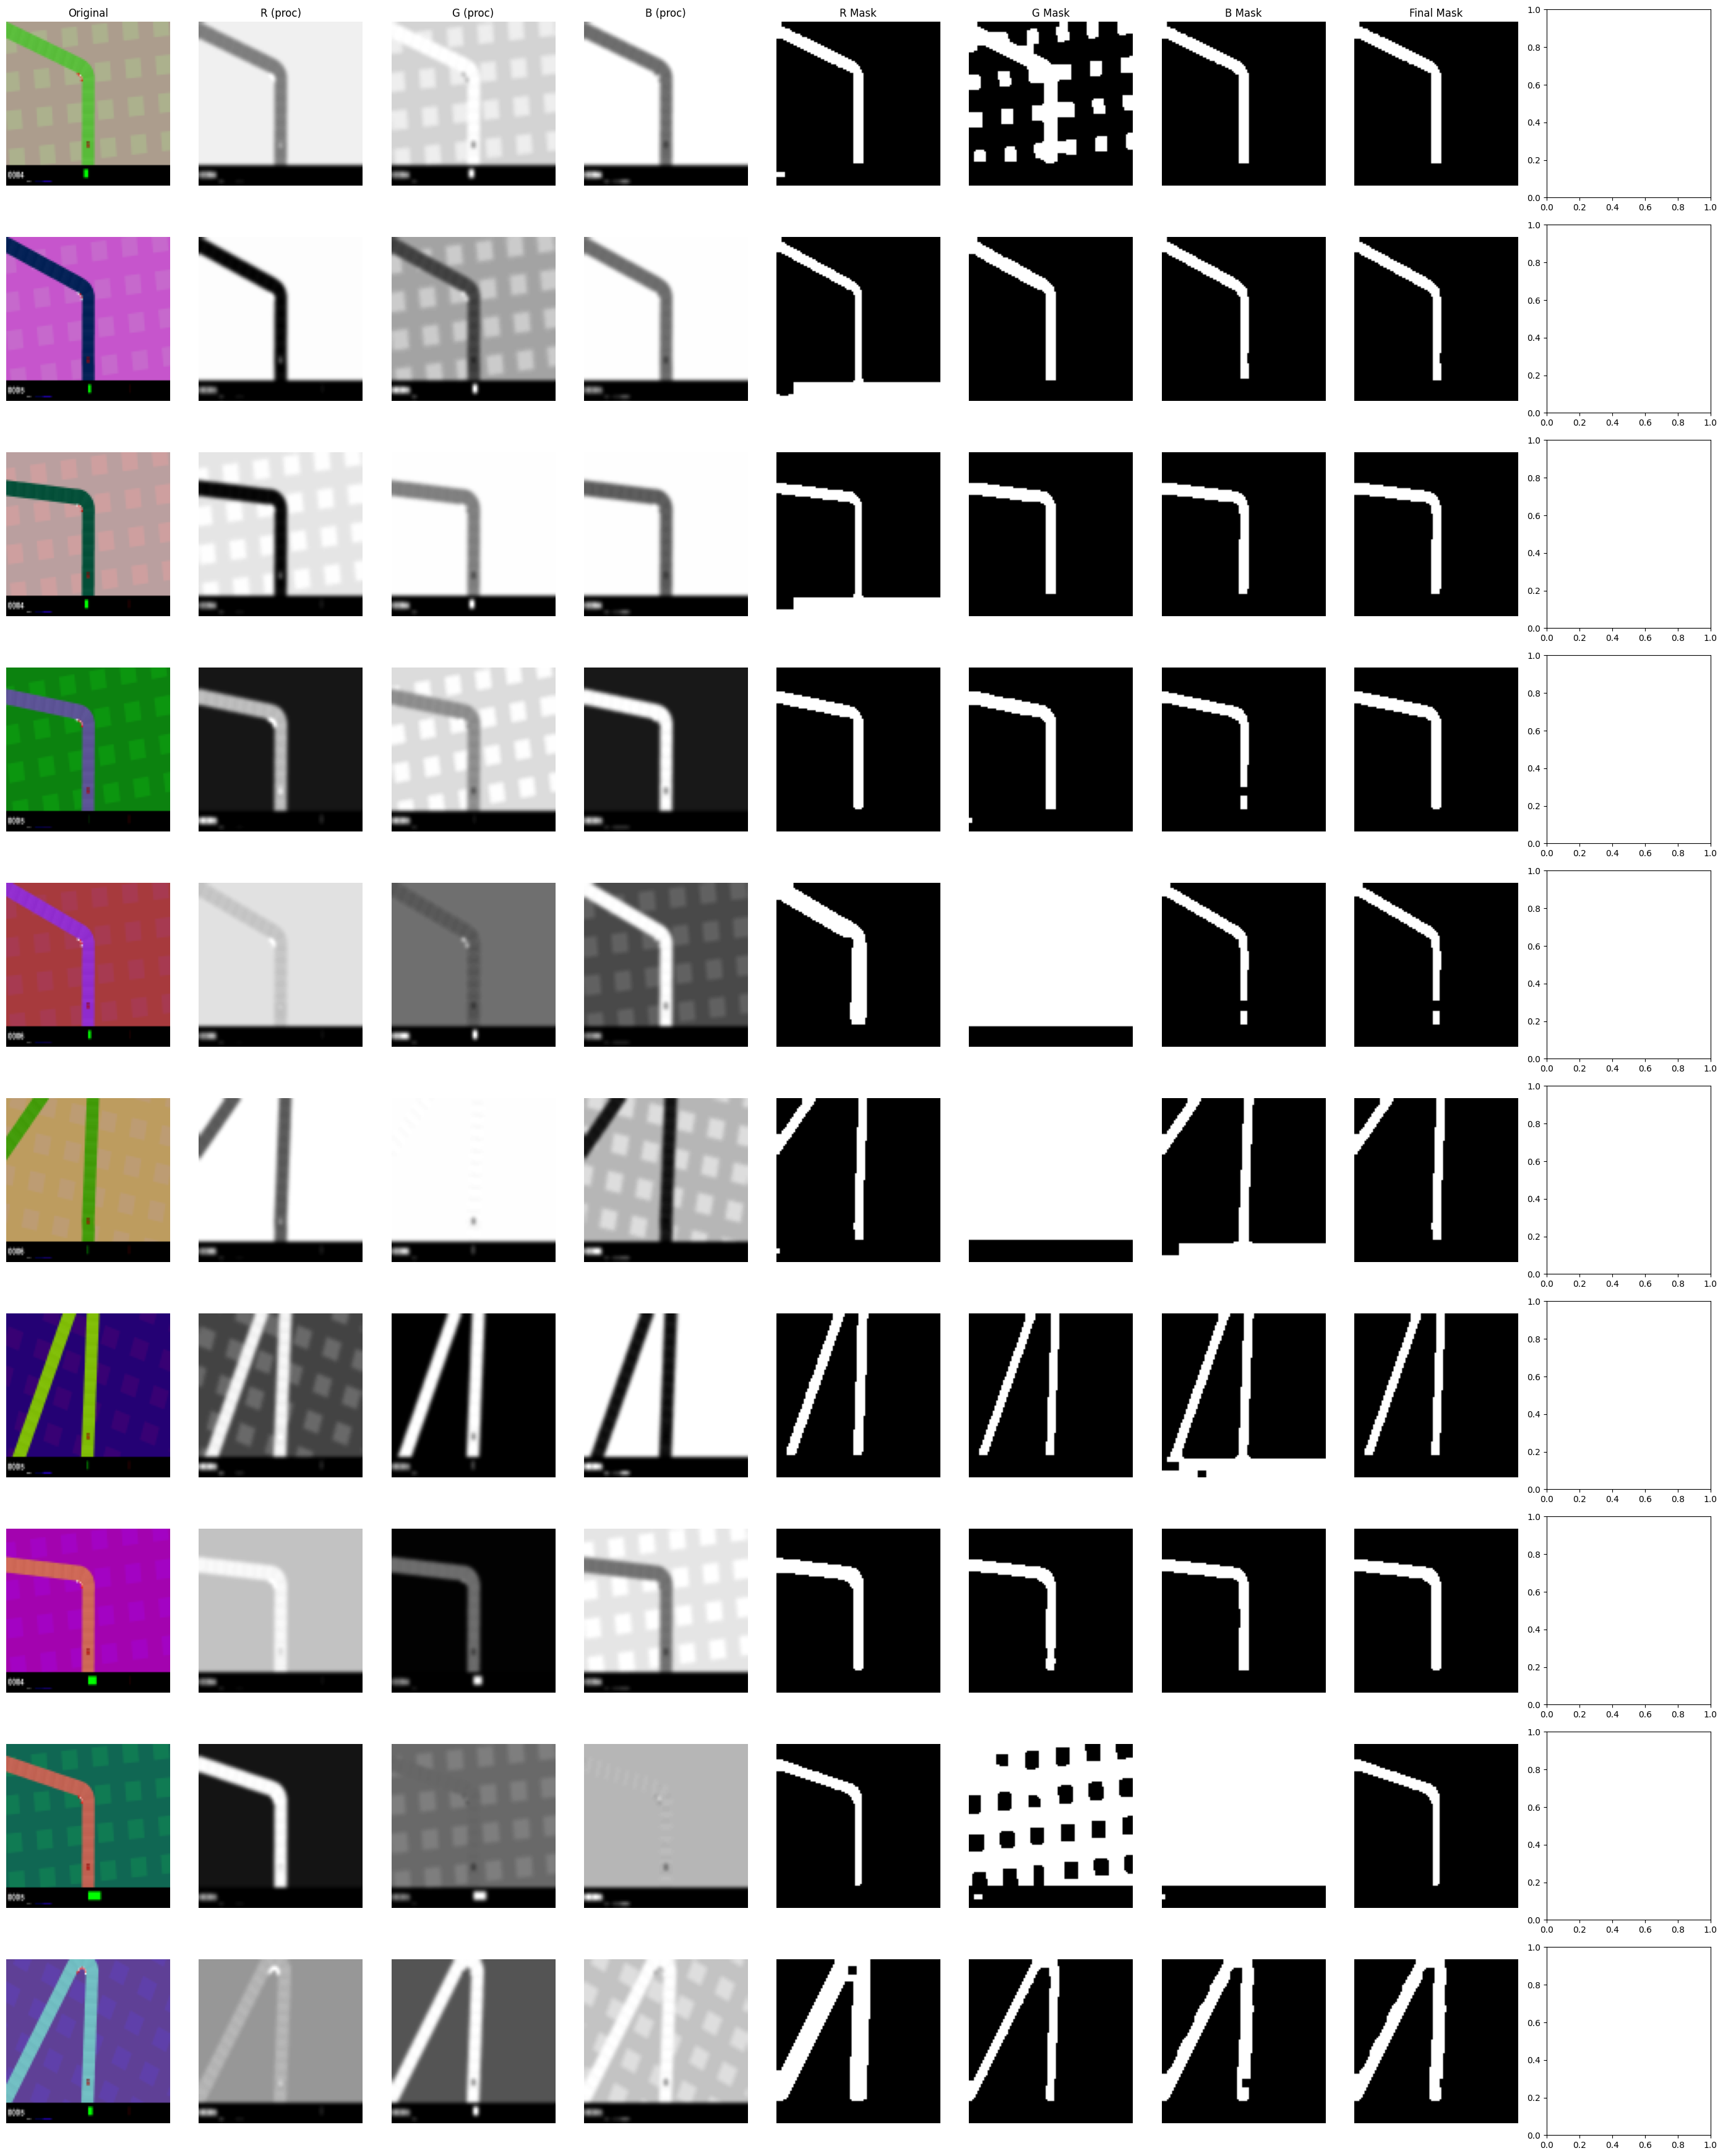

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ------------------ Preprocessing Functions ------------------

def apply_gaussian_blur(channel, ksize=5):
    return cv2.GaussianBlur(channel, (ksize, ksize), 0)

def adjust_brightness(channel, factor=1.2):
    channel = np.clip(np.float32(channel) * factor, 0, 255)
    return np.uint8(channel)

def adjust_saturation_single_channel(channel, factor=1.5):
    # Convert single channel to 3-channel grayscale RGB
    rgb = cv2.merge([channel, channel, channel])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    saturated = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    # Return only one channel (still grayscale-like)
    return cv2.cvtColor(saturated, cv2.COLOR_RGB2GRAY)

def extract_center_value(channel, region_size=7, offset_y=10):
    h, w = channel.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    values = []
    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = channel[y1:y2, x1:x2]
        values.append(np.mean(region))
    return np.mean(values), None

def extract_mask(channel, center_value, tolerance=25):
    diff = np.abs(channel.astype(np.int16) - int(center_value))
    mask = np.uint8(diff < tolerance) * 255
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def mask_quality(mask):
    white = np.sum(mask == 255)
    total = mask.size
    return white / total

def combine_masks(mask_r, mask_g, mask_b, threshold=127):
    qualities = [mask_quality(mask_r), mask_quality(mask_g), mask_quality(mask_b)]
    print(f"Mask qualities (white ratios): {qualities}")

    valid = [(0.05 < q < 0.199) for q in qualities]
    print(f"Valid masks: {valid}")

    masks = [mask_r, mask_g, mask_b]
    used = [m for m, v in zip(masks, valid) if v]

    if not used:
        print("⚠️ All masks are invalid. Returning empty mask.")
        return np.zeros_like(mask_r)

    weight = 1.0 / len(used)
    combined = sum(weight * m for m in used)
    combined = np.clip(combined, 0, 255).astype(np.uint8)
    _, binary = cv2.threshold(combined, threshold, 255, cv2.THRESH_BINARY)
    return binary

# ------------------ Main Plot Function ------------------

def plot_pipeline(num_variations=5, tolerance=15):
    fig, axes = plt.subplots(num_variations, 9, figsize=(28, 3.5 * num_variations))
    titles = [
        "Original", "R (proc)", "G (proc)", "B (proc)",
        "R Mask", "G Mask", "B Mask", "Final Mask", "Overlay"
    ]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state = env.reset()[0]
        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        env.close()

        # === Split channels ===
        r, g, b = cv2.split(state)

        # === Preprocess each channel separately ===
        r_proc = adjust_saturation_single_channel(
            adjust_brightness(apply_gaussian_blur(r, 5), factor=0.9),
            factor=1.5
        )
        g_proc = adjust_saturation_single_channel(
            adjust_brightness(apply_gaussian_blur(g, 5), factor=0.9),
            factor=1.5
        )
        b_proc = adjust_saturation_single_channel(
            adjust_brightness(apply_gaussian_blur(b, 5), factor=0.9),
            factor=1.5
        )

        # === Center values and masks ===
        r_val, _ = extract_center_value(r_proc, region_size=5, offset_y=15)
        g_val, _ = extract_center_value(g_proc, region_size=5, offset_y=15)
        b_val, _ = extract_center_value(b_proc, region_size=5, offset_y=15)

        mask_r = extract_mask(r_proc, r_val, tolerance)
        mask_g = extract_mask(g_proc, g_val, tolerance)
        mask_b = extract_mask(b_proc, b_val, tolerance)

        # === Combine Masks ===
        final_mask = combine_masks(mask_r, mask_g, mask_b, threshold=127)

        # === Overlay Final Mask ===
        overlay = state.copy()
        overlay[final_mask == 255] = [255, 0, 0]

        # === Plot ===
        image_list = [
            state,
            r_proc, g_proc, b_proc,
            mask_r, mask_g, mask_b,
            final_mask,
            # overlay
        ]

        for j, img in enumerate(image_list):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# ✅ Run It
plot_pipeline(num_variations=10, tolerance=15)


In [ ]:
def compare_final_masks_only(tolerance=15):
    env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
    state = env.reset()[0]
    for _ in range(15):
        action = env.action_space.sample()
        state, _, done, _, _ = env.step(action)
        if done:
            break
    env.close()

    # ------------------ Pipeline A (full-image preproc) ------------------
    blurred = apply_gaussian_blur(state)
    brightened = adjust_brightness(blurred, factor=0.9)
    saturated = adjust_saturation(brightened, factor=1.5)
    r1, g1, b1 = cv2.split(saturated)

    r_val1, _ = extract_center_value(r1, region_size=5, offset_y=15)
    g_val1, _ = extract_center_value(g1, region_size=5, offset_y=15)
    b_val1, _ = extract_center_value(b1, region_size=5, offset_y=15)

    mask_r1 = extract_mask(r1, r_val1, tolerance)
    mask_g1 = extract_mask(g1, g_val1, tolerance)
    mask_b1 = extract_mask(b1, b_val1, tolerance)

    final_mask_a = combine_masks(mask_r1, mask_g1, mask_b1)

    # ------------------ Pipeline B (channel-wise preproc) ------------------
    r, g, b = cv2.split(state)
    r2 = adjust_saturation_single_channel(adjust_brightness(apply_gaussian_blur(r), 0.9), 1.5)
    g2 = adjust_saturation_single_channel(adjust_brightness(apply_gaussian_blur(g), 0.9), 1.5)
    b2 = adjust_saturation_single_channel(adjust_brightness(apply_gaussian_blur(b), 0.9), 1.5)

    r_val2, _ = extract_center_value(r2, region_size=5, offset_y=15)
    g_val2, _ = extract_center_value(g2, region_size=5, offset_y=15)
    b_val2, _ = extract_center_value(b2, region_size=5, offset_y=15)

    mask_r2 = extract_mask(r2, r_val2, tolerance)
    mask_g2 = extract_mask(g2, g_val2, tolerance)
    mask_b2 = extract_mask(b2, b_val2, tolerance)

    final_mask_b = combine_masks(mask_r2, mask_g2, mask_b2)

    # ------------------ Show Final Masks ------------------
    fig, axes = plt.subplots(1, 2, figsize=(6, 6))
    axes[0].imshow(final_mask_a, cmap="gray")
    axes[0].set_title("Pipeline A: Full-image Preprocessing")
    axes[0].axis("off")

    axes[1].imshow(final_mask_b, cmap="gray")
    axes[1].set_title("Pipeline B: Channel-wise Preprocessing")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
for _ in range(50):
    compare_final_masks_only()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines.gail import generate_expert_traj
import gym

# Your custom environment setup function
env_fn = make_env()
env = env_fn()  # Initialize the environment

# Train a PPO agent
model = PPO("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=int(1e5))

# Save expert trajectories
generate_expert_traj(model, 'expert_carracing', n_timesteps=int(1e5), n_episodes=10)


/opt/miniconda3/envs/myenv38/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


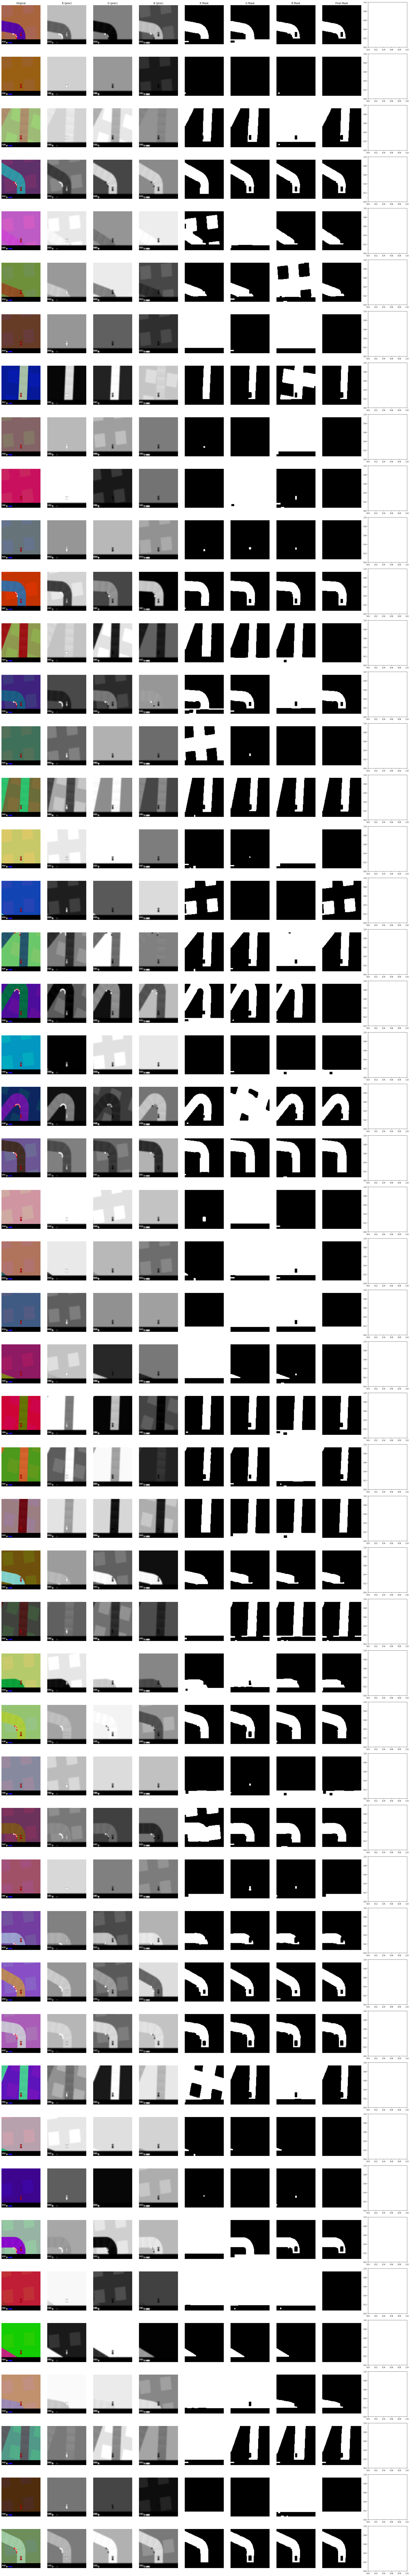

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

# ------------------ Preprocessing Functions ------------------

def apply_gaussian_blur(channel, ksize=5):
    return cv2.GaussianBlur(channel, (ksize, ksize), 0)

def adjust_brightness(channel, factor=1.2):
    channel = np.clip(np.float32(channel) * factor, 0, 255)
    return np.uint8(channel)

def adjust_saturation_single_channel(channel, factor=1.5):
    rgb = cv2.merge([channel, channel, channel])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    saturated = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return cv2.cvtColor(saturated, cv2.COLOR_RGB2GRAY)

def extract_center_value(channel, region_size=7, offset_y=10):
    h, w = channel.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    values = []
    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = channel[y1:y2, x1:x2]
        values.append(np.mean(region))
    return np.mean(values), None

def extract_mask(channel, center_value, tolerance=25):
    diff = np.abs(channel.astype(np.int16) - int(center_value))
    mask = np.uint8(diff < tolerance) * 255
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def mask_quality(mask):
    white = np.sum(mask == 255)
    total = mask.size
    return white / total

def combine_masks(mask_r, mask_g, mask_b, threshold=127):
    qualities = [mask_quality(mask_r), mask_quality(mask_g), mask_quality(mask_b)]
    valid = [(0.05 < q < 0.29) for q in qualities]

    masks = [mask_r, mask_g, mask_b]
    used = [m for m, v in zip(masks, valid) if v]

    if not used:
        return np.zeros_like(mask_r)

    weight = 1.0 / len(used)
    combined = sum(weight * m for m in used)
    combined = np.clip(combined, 0, 255).astype(np.uint8)
    _, binary = cv2.threshold(combined, threshold, 255, cv2.THRESH_BINARY)
    return binary

# ------------------ Main Plot Function ------------------

def plot_pipeline(num_variations=5, tolerance=15):
    fig, axes = plt.subplots(num_variations, 9, figsize=(28, 3.5 * num_variations))
    titles = [
        "Original", "R (proc)", "G (proc)", "B (proc)",
        "R Mask", "G Mask", "B Mask", "Final Mask", "Overlay"
    ]

    for i in range(num_variations):
        env = gym.make("CarRacing-v2", domain_randomize=True, render_mode="rgb_array")
        state, _ = env.reset()

        for _ in range(15):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step(action)
            if done:
                state, _ = env.reset()

        # After 15 steps, set the center value
        r, g, b = cv2.split(state)
        r_val, _ = extract_center_value(r, region_size=5, offset_y=10)
        g_val, _ = extract_center_value(g, region_size=5, offset_y=10)
        b_val, _ = extract_center_value(b, region_size=5, offset_y=10)

        # Random number between 70 and 120 for further steps
        steps_to_process = random.randint(70, 120)

        for _ in range(steps_to_process):
            action = env.action_space.sample()
            state, _, done, _, _ = env.step([0,0.4,0])
            if done:
                state, _ = env.reset()

        # === Split channels ===
        r, g, b = cv2.split(state)

        # === Preprocess each channel separately ===
        r_proc = adjust_saturation_single_channel(
            adjust_brightness(apply_gaussian_blur(r, 5), factor=0.9),
            factor=1.5
        )
        g_proc = adjust_saturation_single_channel(
            adjust_brightness(apply_gaussian_blur(g, 5), factor=0.9),
            factor=1.5
        )
        b_proc = adjust_saturation_single_channel(
            adjust_brightness(apply_gaussian_blur(b, 5), factor=0.9),
            factor=1.5
        )

        # === Extract Center values and masks ===
        mask_r = extract_mask(r_proc, r_val, tolerance)
        mask_g = extract_mask(g_proc, g_val, tolerance)
        mask_b = extract_mask(b_proc, b_val, tolerance)

        # === Combine Masks ===
        final_mask = combine_masks(mask_r, mask_g, mask_b, threshold=127)

        # === Plot ===
        image_list = [
            state,
            r_proc, g_proc, b_proc,
            mask_r, mask_g, mask_b,
            final_mask
        ]

        for j, img in enumerate(image_list):
            ax = axes[i][j]
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            if i == 0:
                ax.set_title(titles[j], fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# ✅ Run it
plot_pipeline(num_variations=50, tolerance=25)


In [2]:
import gym
import numpy as np
import cv2
import pygame
from pygame.locals import *

# Initialize Pygame for keyboard input
pygame.init()
screen = pygame.display.set_mode((1500, 500))  # Adjust window size to accommodate all 4 views
pygame.display.set_caption("CarRacing Control with Mask")

def apply_gaussian_blur(channel, ksize=5):
    return cv2.GaussianBlur(channel, (ksize, ksize), 0)

def adjust_brightness(channel, factor=1.2):
    channel = np.clip(np.float32(channel) * factor, 0, 255)
    return np.uint8(channel)

def adjust_saturation_single_channel(channel, factor=1.5):
    rgb = cv2.merge([channel, channel, channel])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    saturated = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return cv2.cvtColor(saturated, cv2.COLOR_RGB2GRAY)

def extract_center_value(channel, region_size=7, offset_y=10):
    h, w = channel.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    values = []
    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = channel[y1:y2, x1:x2]
        values.append(np.mean(region))
    return np.mean(values), None

def extract_mask(channel, center_value, tolerance=25):
    diff = np.abs(channel.astype(np.int16) - int(center_value))
    mask = np.uint8(diff < tolerance) * 255
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def mask_quality(mask):
    white = np.sum(mask == 255)
    total = mask.size
    return white / total

def combine_masks(mask_r, mask_g, mask_b, threshold=127):
    qualities = [mask_quality(mask_r), mask_quality(mask_g), mask_quality(mask_b)]
    valid = [(0.05 < q < 0.29) for q in qualities]

    masks = [mask_r, mask_g, mask_b]
    used = [m for m, v in zip(masks, valid) if v]

    if not used:
        return np.zeros_like(mask_r)

    weight = 1.0 / len(used)
    combined = sum(weight * m for m in used)
    combined = np.clip(combined, 0, 255).astype(np.uint8)
    _, binary = cv2.threshold(combined, threshold, 255, cv2.THRESH_BINARY)
    return binary

def get_action_from_keys():
    keys = pygame.key.get_pressed()
    action = np.array([0.0, 0.0, 0.0], dtype=np.float32)  # steer, gas, brake
    if keys[K_LEFT] or keys[K_a]:
        action[0] = -1.0
    if keys[K_RIGHT] or keys[K_d]:
        action[0] = 1.0
    if keys[K_UP] or keys[K_w]:
        action[1] = 1.0
    if keys[K_DOWN] or keys[K_s]:
        action[2] = 0.8
    return action

# Create the environment
env = gym.make("CarRacing-v2", render_mode="rgb_array", domain_randomize=True)
obs = env.reset()[0]

clock = pygame.time.Clock()
done = False
frame_count = 0
center_color = None

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True

    action = get_action_from_keys()
    obs, reward, term, trunc, info = env.step(action)
    done = term or trunc

    # Preprocessing
    r, g, b = cv2.split(obs)
    
    # Process each channel
    r_proc = adjust_saturation_single_channel(
        adjust_brightness(apply_gaussian_blur(r, 5), factor=0.9),
        factor=1.5
    )
    g_proc = adjust_saturation_single_channel(
        adjust_brightness(apply_gaussian_blur(g, 5), factor=0.9),
        factor=1.5
    )
    b_proc = adjust_saturation_single_channel(
        adjust_brightness(apply_gaussian_blur(b, 5), factor=0.9),
        factor=1.5
    )

    # If center_color is not set, compute the average color from the center of the image
    if frame_count == 15:
        r_val, _ = extract_center_value(r, region_size=5, offset_y=10)
        g_val, _ = extract_center_value(g, region_size=5, offset_y=10)
        b_val, _ = extract_center_value(b, region_size=5, offset_y=10)
        center_color = (r_val, g_val, b_val)

    # Apply the track mask using center_color
    if center_color is not None:
        mask_r = extract_mask(r_proc, center_color[0], tolerance=25)
        mask_g = extract_mask(g_proc, center_color[1], tolerance=25)
        mask_b = extract_mask(b_proc, center_color[2], tolerance=25)

        # Combine the masks from R, G, B channels
        final_mask = combine_masks(mask_r, mask_g, mask_b, threshold=127)

        # Combine the original image and the 3 individual masks + final mask side-by-side
        mask_r_colored = cv2.cvtColor(mask_r, cv2.COLOR_GRAY2BGR)
        mask_g_colored = cv2.cvtColor(mask_g, cv2.COLOR_GRAY2BGR)
        mask_b_colored = cv2.cvtColor(mask_b, cv2.COLOR_GRAY2BGR)
        final_mask_colored = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)

        # Show all masks side-by-side
        combined = np.hstack((
            obs,  # Original Image
            mask_r_colored,  # Red Channel Mask
            mask_g_colored,  # Green Channel Mask
            mask_b_colored,  # Blue Channel Mask
            final_mask_colored  # Combined Mask
        ))

    else:
        # If center color is not yet set, show the original image repeated
        combined = np.hstack((obs, obs, obs, obs))

    # Display the side-by-side result
    cv2.imshow("CarRacing + Track Masks", cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_count += 1
    clock.tick(30)  # Limit to 30 FPS

# Clean up and close the environment
env.close()
pygame.quit()
cv2.destroyAllWindows()


2025-05-11 20:13:43.454 python[32946:4042758] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-11 20:13:43.454 python[32946:4042758] +[IMKInputSession subclass]: chose IMKInputSession_Modern


KeyboardInterrupt: 

In [ ]:
import gym
import numpy as np
import cv2
import pygame
from pygame.locals import *
import random

# Initialize Pygame for keyboard input
pygame.init()
screen = pygame.display.set_mode((1500, 500))  # Adjust window size to accommodate all 4 views
pygame.display.set_caption("CarRacing Control with Mask")

def apply_gaussian_blur(channel, ksize=5):
    return cv2.GaussianBlur(channel, (ksize, ksize), 0)

def adjust_brightness(channel, factor=1.2):
    channel = np.clip(np.float32(channel) * factor, 0, 255)
    return np.uint8(channel)

def adjust_saturation_single_channel(channel, factor=1.5):
    rgb = cv2.merge([channel, channel, channel])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    saturated = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return cv2.cvtColor(saturated, cv2.COLOR_RGB2GRAY)

def extract_center_value(channel, region_size=7, offset_y=10):
    h, w = channel.shape
    cx = w // 2
    cy = h // 2
    offsets = [-offset_y, 0, offset_y]
    values = []
    for off in offsets:
        y1 = cy + off - region_size // 2
        y2 = cy + off + region_size // 2
        x1 = cx - region_size // 2
        x2 = cx + region_size // 2
        region = channel[y1:y2, x1:x2]
        values.append(np.mean(region))
    return np.mean(values), None

def extract_mask(channel, center_value, tolerance=25):
    diff = np.abs(channel.astype(np.int16) - int(center_value))
    mask = np.uint8(diff < tolerance) * 255
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def mask_quality(mask):
    white = np.sum(mask == 255)
    total = mask.size
    return white / total

def combine_masks(mask_r, mask_g, mask_b, threshold=127):
    qualities = [mask_quality(mask_r), mask_quality(mask_g), mask_quality(mask_b)]
    valid = [(0.05 < q < 0.29) for q in qualities]

    masks = [mask_r, mask_g, mask_b]
    used = [m for m, v in zip(masks, valid) if v]

    if not used:
        return np.zeros_like(mask_r)

    weight = 1.0 / len(used)
    combined = sum(weight * m for m in used)
    combined = np.clip(combined, 0, 255).astype(np.uint8)
    _, binary = cv2.threshold(combined, threshold, 255, cv2.THRESH_BINARY)
    return binary

def get_action_from_keys():
    keys = pygame.key.get_pressed()
    action = np.array([0.0, 0.0, 0.0], dtype=np.float32)  # steer, gas, brake
    if keys[K_LEFT] or keys[K_a]:
        action[0] = -1.0
    if keys[K_RIGHT] or keys[K_d]:
        action[0] = 1.0
    if keys[K_UP] or keys[K_w]:
        action[1] = 1.0
    if keys[K_DOWN] or keys[K_s]:
        action[2] = 0.8
    return action

# Create the environment
env = gym.make("CarRacing-v2", render_mode="rgb_array", domain_randomize=True)
obs = env.reset()[0]

clock = pygame.time.Clock()
done = False
frame_count = 0
center_color = None

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True

    action = get_action_from_keys()
    obs, reward, term, trunc, info = env.step(action)
    done = term or trunc

    # Preprocessing
    r, g, b = cv2.split(obs)
    
    # Process each channel
    r_proc = adjust_saturation_single_channel(
        adjust_brightness(apply_gaussian_blur(r, 5), factor=0.9),
        factor=1.5
    )
    g_proc = adjust_saturation_single_channel(
        adjust_brightness(apply_gaussian_blur(g, 5), factor=0.9),
        factor=1.5
    )
    b_proc = adjust_saturation_single_channel(
        adjust_brightness(apply_gaussian_blur(b, 5), factor=0.9),
        factor=1.5
    )

    # If center_color is not set, compute the average color from the center of the image
    if frame_count == 15:
        r_val, _ = extract_center_value(r, region_size=5, offset_y=10)
        g_val, _ = extract_center_value(g, region_size=5, offset_y=10)
        b_val, _ = extract_center_value(b, region_size=5, offset_y=10)
        center_color = (r_val, g_val, b_val)

    # Apply the track mask using center_color
    if center_color is not None:
        mask_r = extract_mask(r_proc, center_color[0], tolerance=25)
        mask_g = extract_mask(g_proc, center_color[1], tolerance=25)
        mask_b = extract_mask(b_proc, center_color[2], tolerance=25)

        # Combine the masks from R, G, B channels
        final_mask = combine_masks(mask_r, mask_g, mask_b, threshold=127)

        # Combine the original image and the 3 individual masks + final mask side-by-side
        mask_r_colored = cv2.cvtColor(mask_r, cv2.COLOR_GRAY2BGR)
        mask_g_colored = cv2.cvtColor(mask_g, cv2.COLOR_GRAY2BGR)
        mask_b_colored = cv2.cvtColor(mask_b, cv2.COLOR_GRAY2BGR)
        final_mask_colored = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)

        # Show all masks side-by-side
        combined = np.hstack((
            obs,  # Original Image
            mask_r_colored,  # Red Channel Mask
            mask_g_colored,  # Green Channel Mask
            mask_b_colored,  # Blue Channel Mask
            final_mask_colored  # Combined Mask
        ))

        # Save the RGB and mask image side by side at random frames
        if random.randint(1, 200) == 1:  # Randomly decide to save every frame
            combined_bgr = cv2.cvtColor(combined, cv2.COLOR_RGB2BGR)
            cv2.imwrite(f"2_screenshot_{frame_count}.png", combined_bgr)

    else:
        # If center color is not yet set, show the original image repeated
        combined = np.hstack((obs, obs, obs, obs))

    # Display the side-by-side result
    cv2.imshow("CarRacing + Track Masks", cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_count += 1
    clock.tick(30)  # Limit to 30 FPS

# Clean up and close the environment
env.close()
pygame.quit()
cv2.destroyAllWindows()


KeyboardInterrupt: 

: 